Run CCC analysis using LIANA+Tensorcell2cell to analyse communication between T cells (except gd) and DCs in the ABC and DT_ABC contexts. In this version, we add Macrophages and monocytes to the analysis. 

In [1]:
server = 'mando'
if (server == 'jabba'){
    data_path = '/data3/hratch/norcross_abc/'
    gpu_use = F
}else if (server == 'mando'){
    data_path = '/data/hratch/norcross_abc/'
    gpu_use = T
}

library(reticulate, quietly = T)
if (gpu_use){
    device<-'cuda:0'
    tensorly <- reticulate::import('tensorly')
    tensorly$set_backend('pytorch')
}else{
    device<-NULL
}

n.cores<-30
env_name = 'norcross_abc'

In [2]:
suppressPackageStartupMessages({
    suppressWarnings({
        library(liana, quietly = T)
        library(decoupleR, quietly = T)

        library(Seurat, quietly = T)
        
        library(dplyr, quietly = T)
        library(tidyr, quietly = T)
        library(magrittr, quietly = T)
        library(tibble, quietly = T)
        library(reshape2, quietly = T)
        library(stringr)
        library(plyr, quietly = T)
        library(textshape, quietly = T)
        
        library(ggplot2, quietly = T)
        library(circlize, quietly = T)
        library(RColorBrewer, quietly = T)
        
        # library(textshape, quietly = T)
        c2c <- reticulate::import(module = "cell2cell", as="c2c")
    })
})

Set the pipeline parameters (things we can potentially adjust to get different outputs):

In [3]:
params<-list(return_all = FALSE, #whether to return all LRs in liana after filtering for expr_prop
             filter_specificity = FALSE, # whether to filter scores by specificty
             filter_thresh = 0.05, # specificity filter threshold
             filter_specificity_how = 'fill', # or exclude -- fill insignifanct interactions with min or remove alltogether
             lr_fill_by = NaN, # or 0 or NaN -- what to use in the lr_fill tc2c argument
             how = 'outer' # what to use in the how tc2c argument
            )

Load the data:

In [4]:
abc.integrated<-readRDS(paste0(data_path, 'processed/abc_annotated.RDS'))

Subset to the cell types and contexts of interest:

In [5]:
cell.types<-c('T-cells', 'cDC_1', 'cDC_2', 'Xcr1+ DC_1', 'Xcr1+ DC_2', 'pDC', 'ncMono', 'Mf')
contexts<-c('ABC', 'DT_ABC')
abc.ccc<-subset(abc.integrated, subset = (Cell.Type.Level1 %in% cell.types) & (Cell.Type.Level2 != 'gd-T') &
                                        (orig.ident %in% contexts))
Idents(abc.ccc)<-'Cell.Type.Level2'

Format to input to LIANA:

In [6]:
# format into sce object
DefaultAssay(abc.ccc)<-'RNA'
abc.ccc@meta.data <-abc.ccc@meta.data %>% droplevels()
abc.ccc.sce<-Seurat::as.SingleCellExperiment(abc.ccc)

In [7]:
# map LIANA consensus resource to mouse
suppressMessages({
    suppressWarnings({
        op_resource <- liana::select_resource("Consensus")[[1]]

        # Generate orthologous resource
        ortholog_resource <- liana::generate_homologs(op_resource = op_resource,
                                               target_organism = 10090) # mouse
    })
})

Run liana for each context and calculate the consensus rank score:

In [8]:
# suppressWarnings({
#     abc.ccc.sce<-liana_bysample(sce = abc.ccc.sce, 
#                idents_col = 'Cell.Type.Level2', 
#                sample_col = 'orig.ident',
#                assay.type='logcounts', # log-normalized counts
#                verbose = T, 
#               aggregate_how = 'both', # consensus magnitude AND specifity score
#                 resource = 'custom', 
#                 external_resource = ortholog_resource, # consensus resource in mouse
#                min_cells = 5, # default min cells to be considered
#                expr_prop = 0.05, # expressed in atleast 5% of cells to be scored
#                return_all = params$return_all, # assign a low score to those that don't pass expr_prop
#                 parallelize = TRUE, workers = n.cores,
#               )
# })
# saveRDS(abc.ccc.sce@metadata$liana_res, paste0(data_path, 'interim/', 'v2_liana_bysample.rds'))

abc.ccc.sce@metadata$liana_res<-readRDS(paste0(data_path, 'interim/', 'v2_liana_bysample.rds'))

If filtering for specificity rank, will change # of interactions in the contexts as follows:

In [9]:
sapply(abc.ccc.sce@metadata$liana_res, function(x) dim(x)[[1]])
       
if (params$filter_specificity_how == 'exclude'){
        sapply(abc.ccc.sce@metadata$liana_res, function(x) dim(x[x$specificity_rank <= params$filter_thresh, ])[[1]])
    }else if (params$filter_specificity_how == 'fill'){
        sapply(abc.ccc.sce@metadata$liana_res, function(x) dim(x[x$specificity_rank > params$filter_thresh, ])[[1]])
    }


ABC DT_ABC 
 56311  49054

ABC DT_ABC 
 45137  40384

In [10]:
if (params$filter_specificity){
    liana_res<-list()
    for (sample.name in names(abc.ccc.sce@metadata$liana_res)){
        x<-abc.ccc.sce@metadata$liana_res[[sample.name]]
        if (params$filter_specificity_how == 'exclude'){
            x<-x[x$specificity_rank <= params$filter_thresh, ] # eliminate those under threshold
        }else if (params$filter_specificity_how == 'fill'){
            x[x$specificity_rank > params$filter_thresh, 'magnitude_rank']<-max(x$magnitude_rank) # replace with "lowest" value (max because magnitude rank orders lower values as higher importance)
        }
        abc.ccc.sce@metadata$liana_res[[sample.name]]<-x
    }
}

Run Tensor-cell2cell

In [11]:
abc.ccc.sce@metadata$liana_res<-liana:::preprocess_scores(context_df_dict = abc.ccc.sce@metadata$liana_res, 
                                 score_col = 'magnitude_rank', # score to preprocess
                                  outer_fraction = 1/3, # only keep cells/LRs present in atleast in 1/3 of contexts
                                                        # outer_fract shouldn't change things since there are only 3 samples
                                  invert = TRUE, # since magnitude has lower scores being more valuable
                                  invert_fun = function(x) 1-x, 
                                  non_negative = TRUE, # shouldn't effect things since all magnitude ranks are positive
                                  non_negative_fill = 0, 
                                  verbose = T
                                 )

Inverting `magnitude_rank`!

Inverting `magnitude_rank`!



In [12]:
score_col = 'magnitude_rank'

if (params$lr_fill_by == 'min'){
    lr.fill.value<-min(sapply(abc.ccc.sce@metadata$liana_res, function(x) min(x[[score_col]])))
}else if (is.numeric(params$lr_fill_by)){
    lr.fill.value<-params$lr_fill_by
}
lr.fill.value

[1] NaN

In [13]:
# # build tensor
# tensor <- liana::liana_tensor_c2c(sce = abc.ccc.sce,
#                                   context_df_dict = NULL, 
#                                   score_col = 'magnitude_rank', 
#                                   how = params$how, 
#                                   lr_fill = lr.fill.value,
#                                   cell_fill = 0, 
#                                   context_order = levels(abc.ccc.sce@colData$orig.ident), 
#                                   sort_elements = TRUE, 
#                                   conda_env = env_name, 
#                                   build_only = TRUE, 
#                                   device = device)

# # decompose tensor
# tensor<-liana::decompose_tensor(tensor = tensor, 
#                          rank = NULL, 
#                          tf_optimization = 'regular', # CHANGE TO ROBUST
#                          elbow_metric = 'error', # Metric to use in the elbow analysis.
#                          smooth_elbow = FALSE, # Whether smoothing the metric of the elbow analysis.
#                          upper_rank=25, # Max number of factors to try in the elbow analysis
#                          init = 'svd', # Initialization method of the tensor factorization
#                          factors_only = FALSE, 
#                         )
# reticulate::py_save_object(object = tensor, 
#                            filename = paste0(paste0(data_path, 'processed/', 'v2_ccc_tensor.pkl')))

tensor<-reticulate::py_load_object(paste0(paste0(data_path, 'processed/', 'v2_ccc_tensor.pkl')))

# Downstream Analysis

In [14]:
write.csv(tensor$factors$interactions, 
          paste0(data_path, 'interim/', 'v2_lr_loadings.csv'))

In [15]:
# basic formatting
factors<-liana:::format_c2c_factors(tensor$factors)

# ordering categories
f.c<-factors$contexts
f.c[['context']]<-factor(f.c$context, levels(abc.ccc.sce@colData$orig.ident))
factors[['contexts']]<-f.c
for (ct in c('senders', 'receivers')){
    f.ct<-factors[[ct]]
    f.ct[['celltype']]<-factor(f.ct$celltype, levels(abc.ccc.sce@colData$Cell.Type.Level2))
    factors[[ct]]<-f.ct
}
abc.ccc.sce@metadata$tensor_res<-factors

abc.ccc.sce@colData[['group']] = abc.ccc.sce@colData[['orig.ident']] # must have a "group" for plotting

[1] "The identified tensor rank is 9"


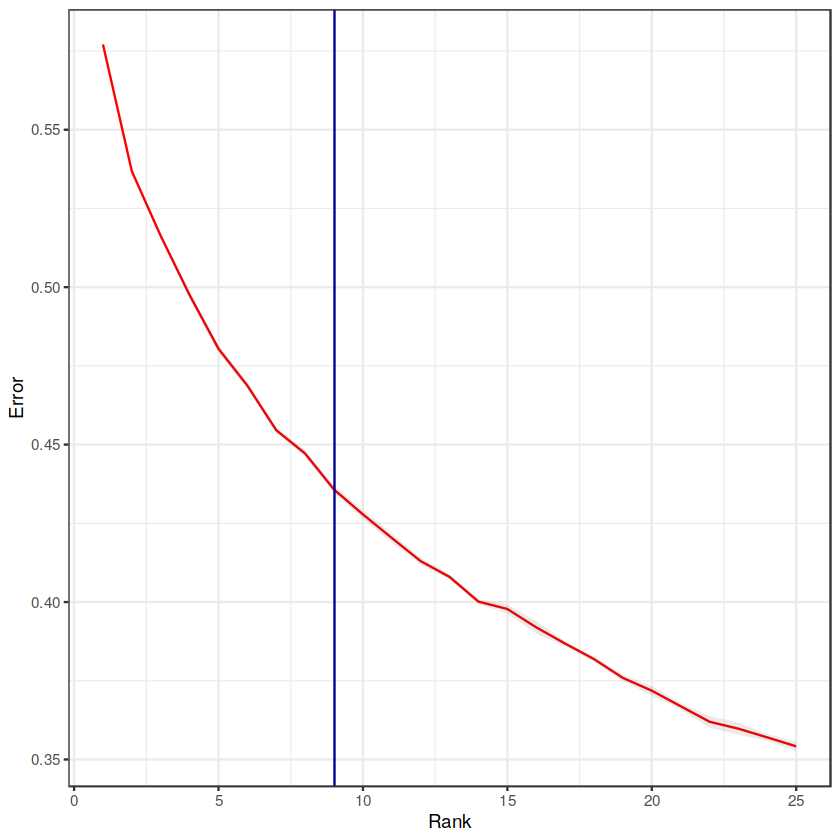

In [16]:
print(paste0('The identified tensor rank is ', tensor$rank))

# Estimate standard error
error_average <- tensor$elbow_metric_raw %>%
    t() %>%
    as.data.frame() %>%
    mutate(rank=row_number()) %>% 
    pivot_longer(-rank, names_to = "run_no", values_to = "error") %>%
    group_by(rank) %>%
    summarize(average = mean(error),
              N = n(),
              SE.low = average - (sd(error)/sqrt(N)),
              SE.high = average + (sd(error)/sqrt(N))
           )

# plot
error_average %>%
    ggplot(aes(x=rank, y=average), group=1) +
    geom_line(col='red') + 
    geom_ribbon(aes(ymin = SE.low, ymax = SE.high), alpha = 0.1) +
    geom_vline(xintercept = tensor$rank, colour='darkblue') + # rank of interest
    theme_bw() +
    labs(y="Error", x="Rank")

In [17]:
# addapt from liana
plot_c2c_overview <- function(sce, group_col, sample_col, factors.of.interest=NULL){

    factors <- get_c2c_factors(sce, group_col, sample_col)
    if (is.null(factors.of.interest)){
        factors.of.interest<-names(which(sapply(names(factors$contexts), function(x) startsWith(x, 'Factor.'))))
    }

    # Contexts
    contexts <- factors$contexts %>%
        pivot_longer(cols = -c("context", group_col),
                     names_to = "factor", values_to = "loadings"
        ) %>%
        filter(factor %in% factors.of.interest) %>%
        ggplot(aes(x=context, y=loadings, fill=.data[[group_col]])) +
        geom_bar(stat="identity") +
        facet_grid(factor ~ .) +
        theme_bw(base_size = 14) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank(),
              strip.text.y = element_blank(),
              plot.title = element_text(hjust = 0.5)) +
        ggtitle('Contexts') +
        ylab(NULL)

    # lr
    lr <- factors$interactions %>%
        pivot_longer(-lr, names_to = "factor", values_to = "loadings") %>%
        filter(factor %in% factors.of.interest) %>%
        ggplot(aes(x=lr, y=loadings)) +
        geom_bar(stat="identity") +
        facet_grid(factor ~ ., scales = "free_y") +
        theme_bw(base_size = 14) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank(),
              strip.background = element_blank(),
              strip.text.y = element_blank(),
              plot.title = element_text(hjust = 0.5)) +
        ggtitle('Interactions') +
        ylab(NULL)


    # Sender cells
    senders <- factors$senders %>%
        pivot_longer(cols = -celltype,
                     names_to = "factor", values_to = "loadings"
        ) %>%
        filter(factor %in% factors.of.interest) %>%
        ggplot(aes(x=celltype, y=loadings,
                   fill=celltype)) +
        geom_bar(stat="identity") +
        facet_grid(factor ~ .) +
        theme_bw(base_size = 14) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank(),
              strip.background = element_blank(),
              strip.text.y = element_blank(),
              plot.title = element_text(hjust = 0.5)) +
        ylab(NULL) +
        ggtitle('Senders')

    # Receiver cells
    receivers <- factors$receivers %>%
        pivot_longer(cols = -celltype,
                     names_to = "factor", values_to = "loadings"
        ) %>%
        filter(factor %in% factors.of.interest) %>%
        ggplot(aes(x=celltype, y=loadings,
                   fill=celltype)) +
        geom_bar(stat="identity") +
        facet_grid(factor ~ .) +
        theme_bw(base_size = 14) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              strip.background = element_blank(),
              axis.ticks.x=element_blank(),
              strip.text.y = element_text(size=15, face = "bold"),
              plot.title = element_text(hjust = 0.5)) +
        ylab(NULL) +
        ggtitle('Receivers')

    # Assemble overview plot
    overview <- patchwork::wrap_plots(list(contexts,
                                           lr,
                                           senders,
                                           receivers
    ),
    ncol=4,
    nrow(1)) +
        patchwork::plot_layout(guides = "collect")

    grid::grid.draw(overview)
}

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(group_col)

  # Now:
  data %>% select(all_of(group_col))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


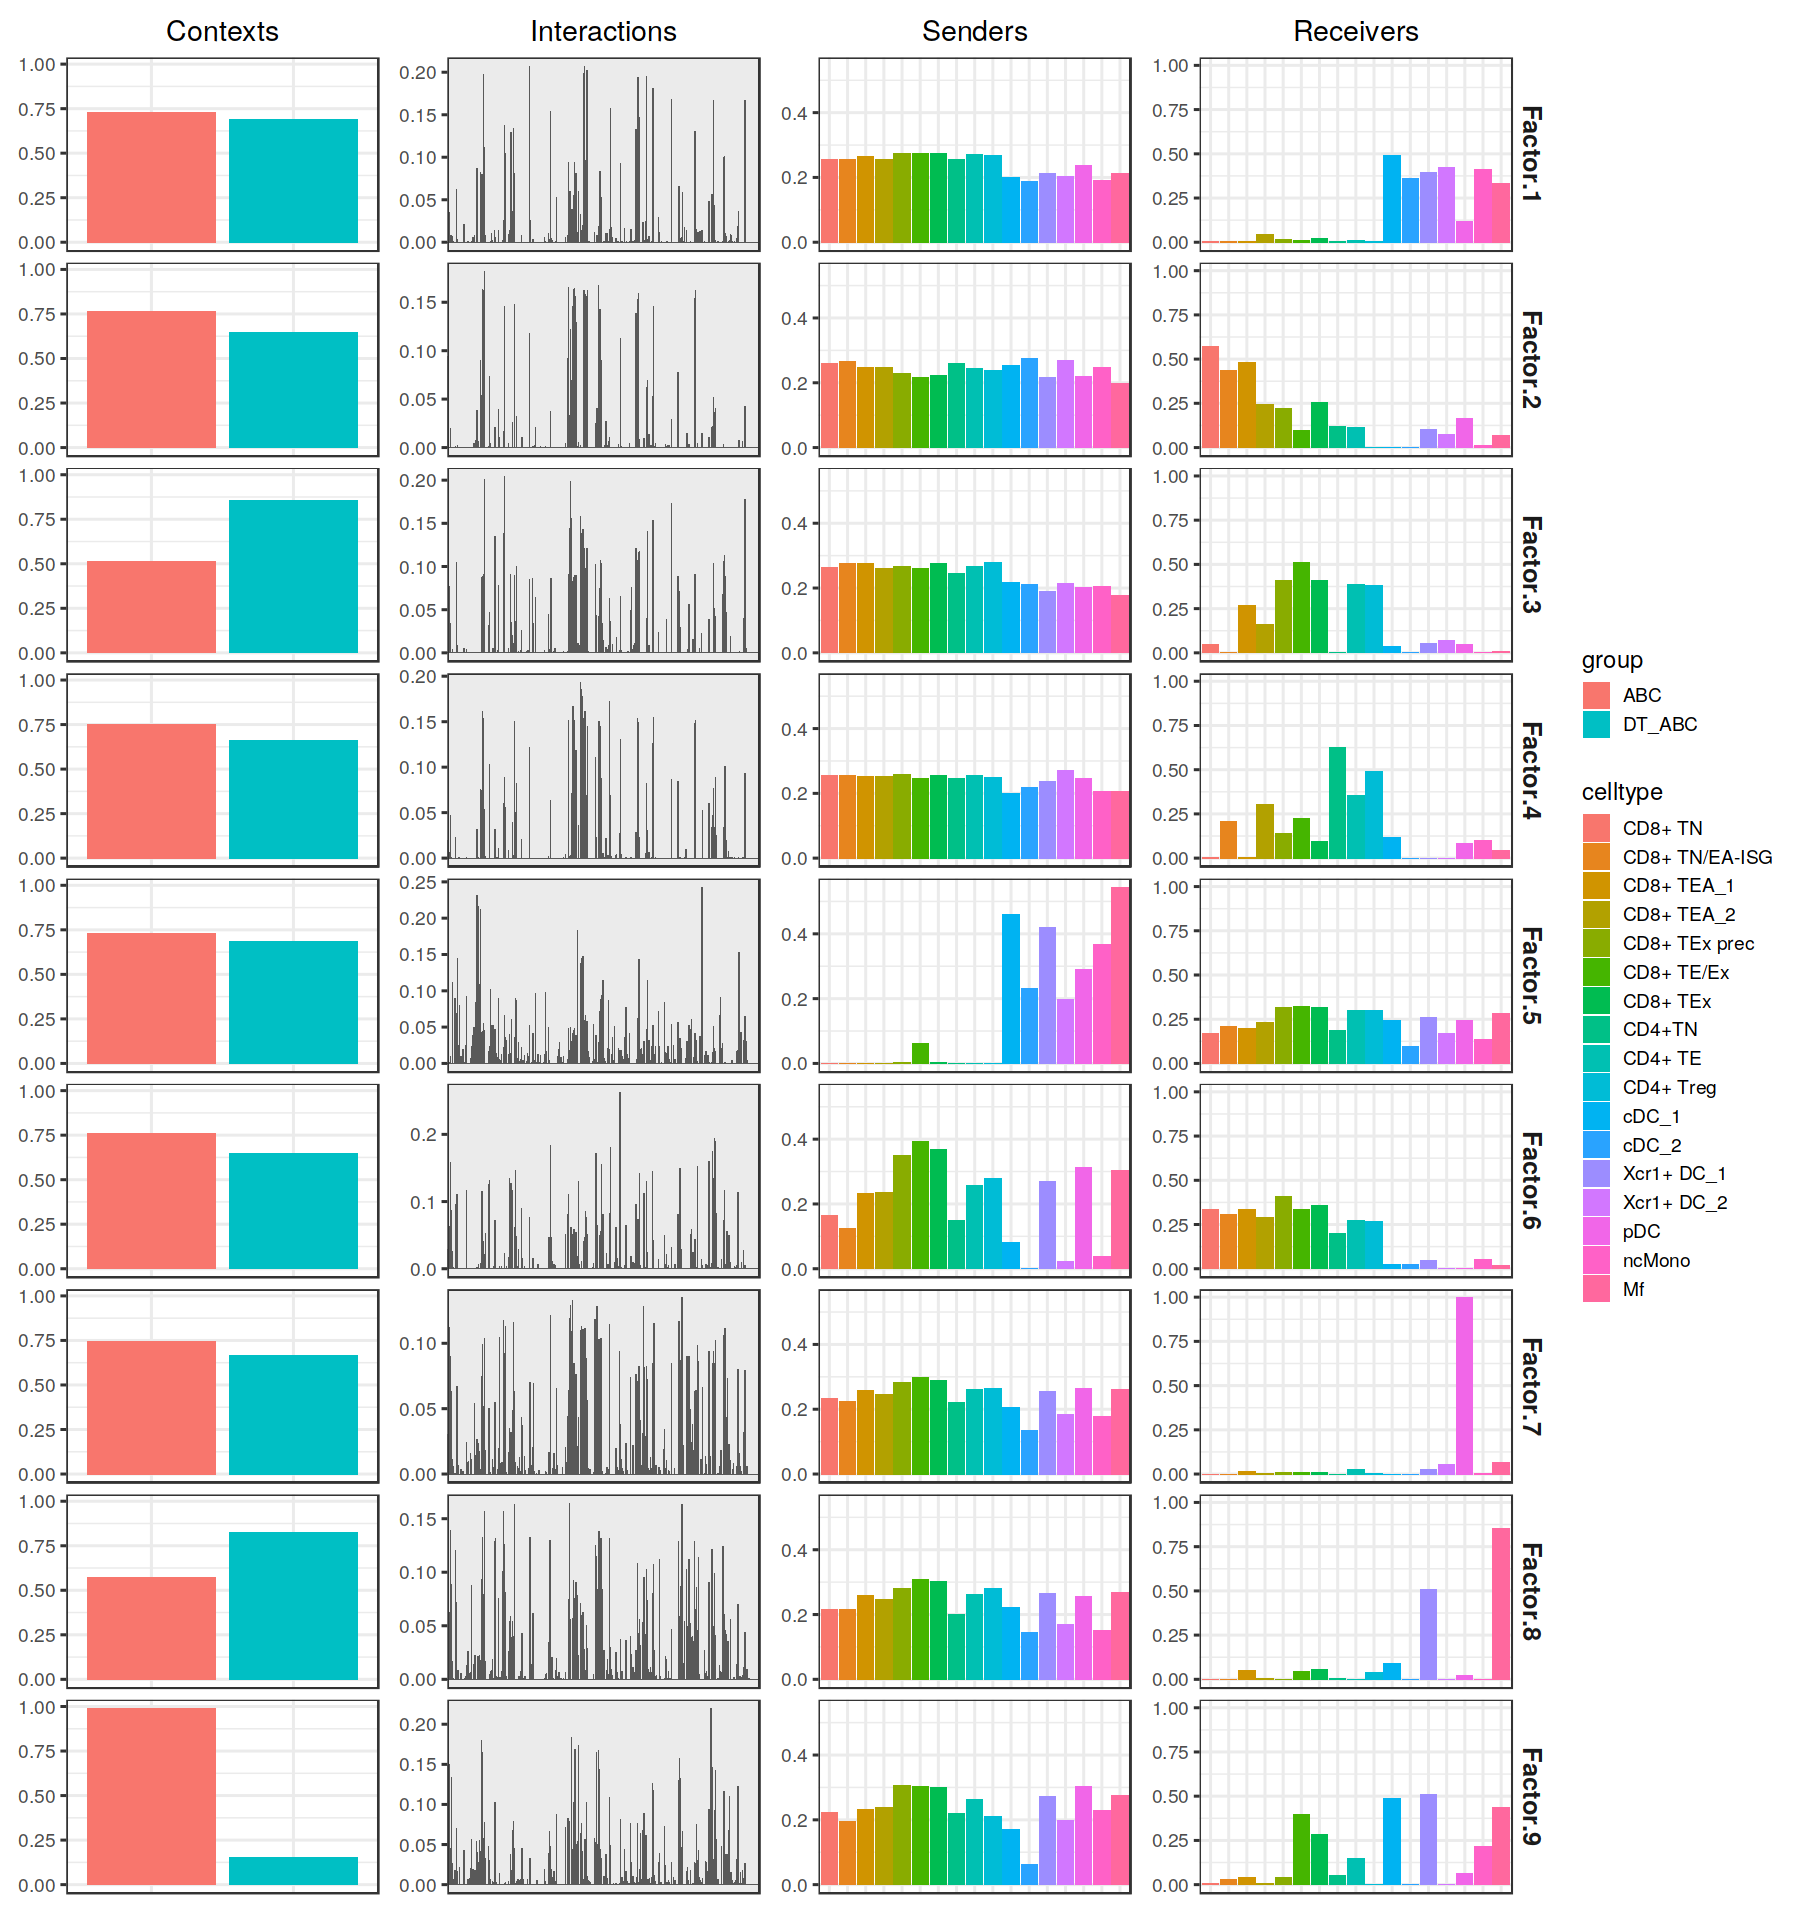

In [19]:
h_ = 16
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

plot_c2c_overview(sce = abc.ccc.sce, group_col = 'group', sample_col = 'orig.ident')

Context-specific factors are: Factors 3, 8 and 9

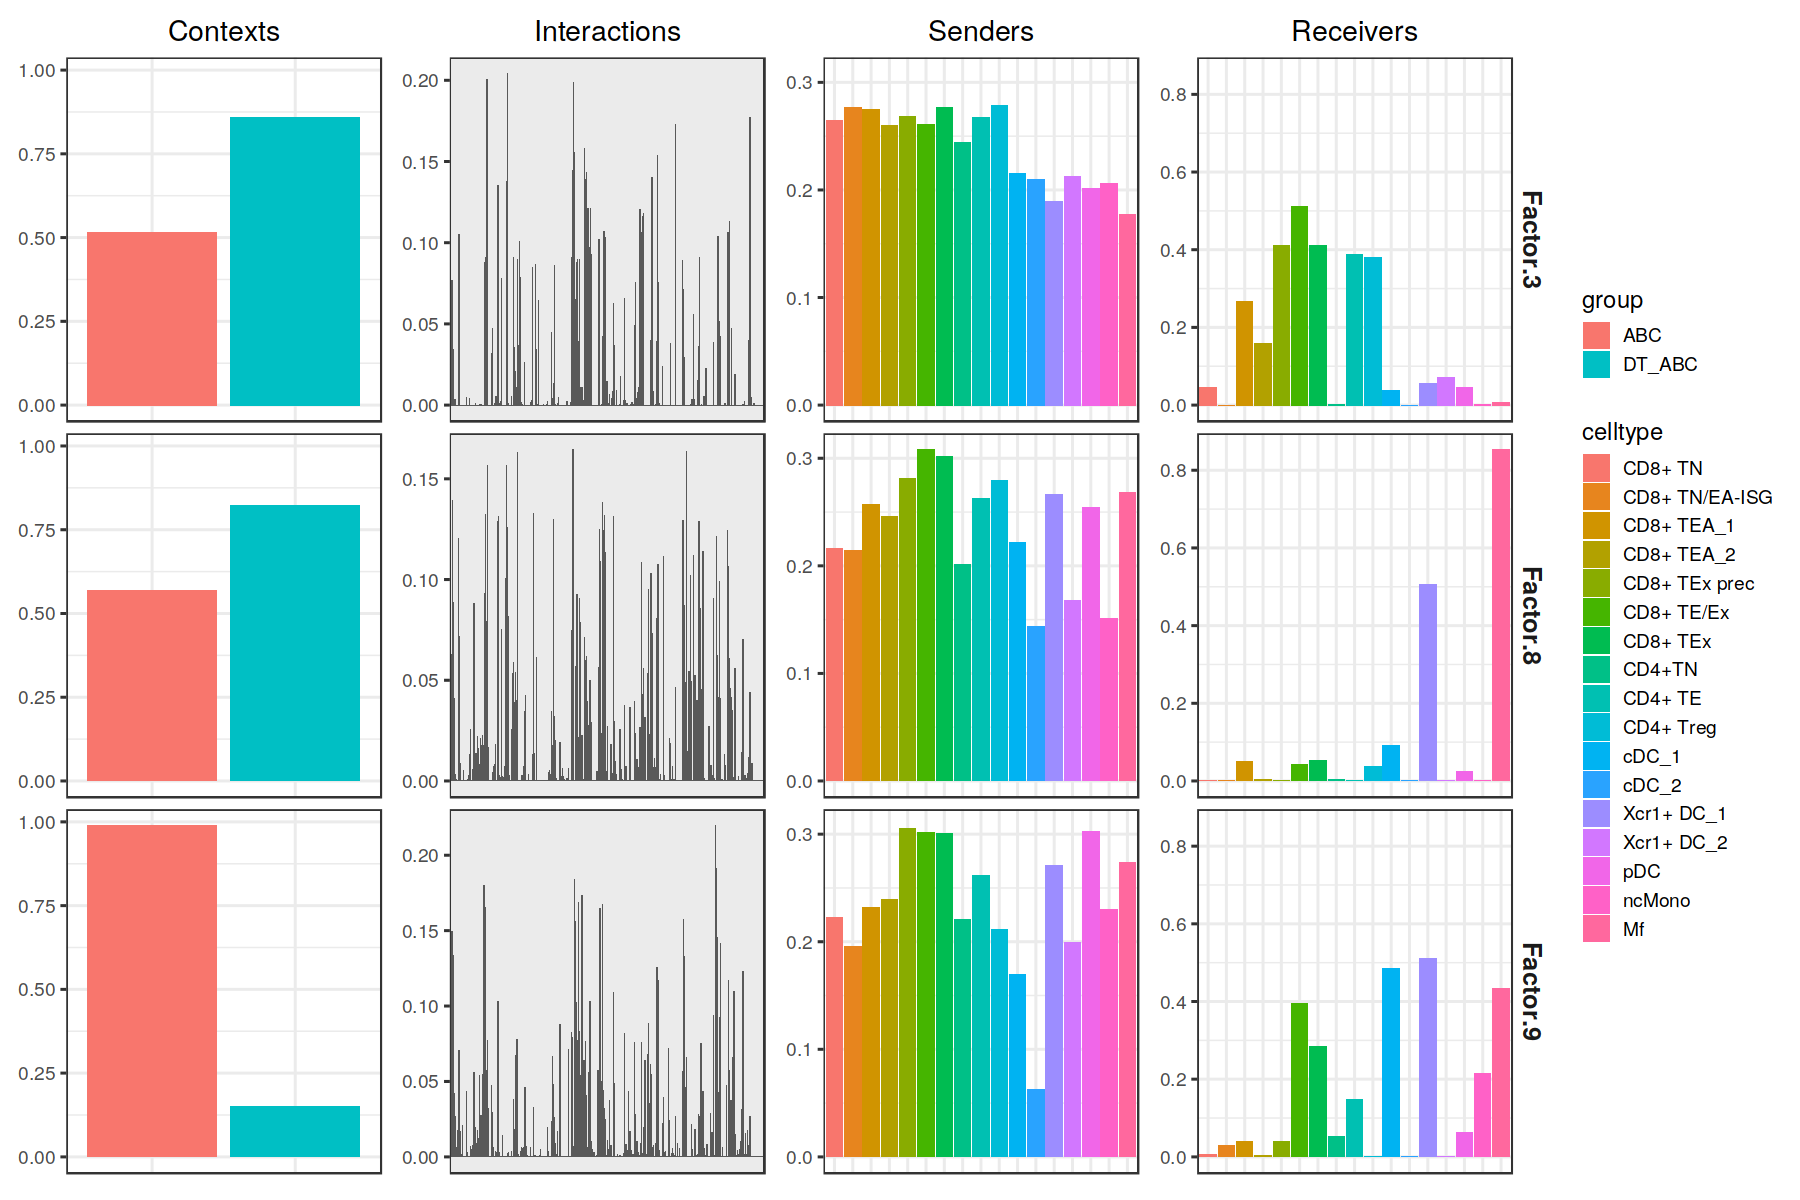

In [20]:
h_ = 10
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)
fos<-c('3', '8', '9')
plot_c2c_overview(sce = abc.ccc.sce, group_col = 'group', sample_col = 'orig.ident', 
                 factors.of.interest = paste0('Factor.', fos))

In [21]:
calculate_gini(factors$senders) %>% arrange(gini)

factor,gini
<chr>,<dbl>
Factor.4,0.04662789
Factor.2,0.05245001
Factor.1,0.07457592
Factor.3,0.08376764
Factor.7,0.10152487
Factor.8,0.12061640
Factor.9,0.14044531
Factor.6,0.34656555
Factor.5,0.68959615


In [22]:
calculate_gini(factors$receivers) %>% arrange(gini)

factor,gini
<chr>,<dbl>
Factor.5,0.1723785
Factor.6,0.4520889
Factor.2,0.5527723
Factor.4,0.6069823
Factor.3,0.6185852
Factor.9,0.6444110
Factor.1,0.6505925
Factor.8,0.8695110
Factor.7,0.9298938


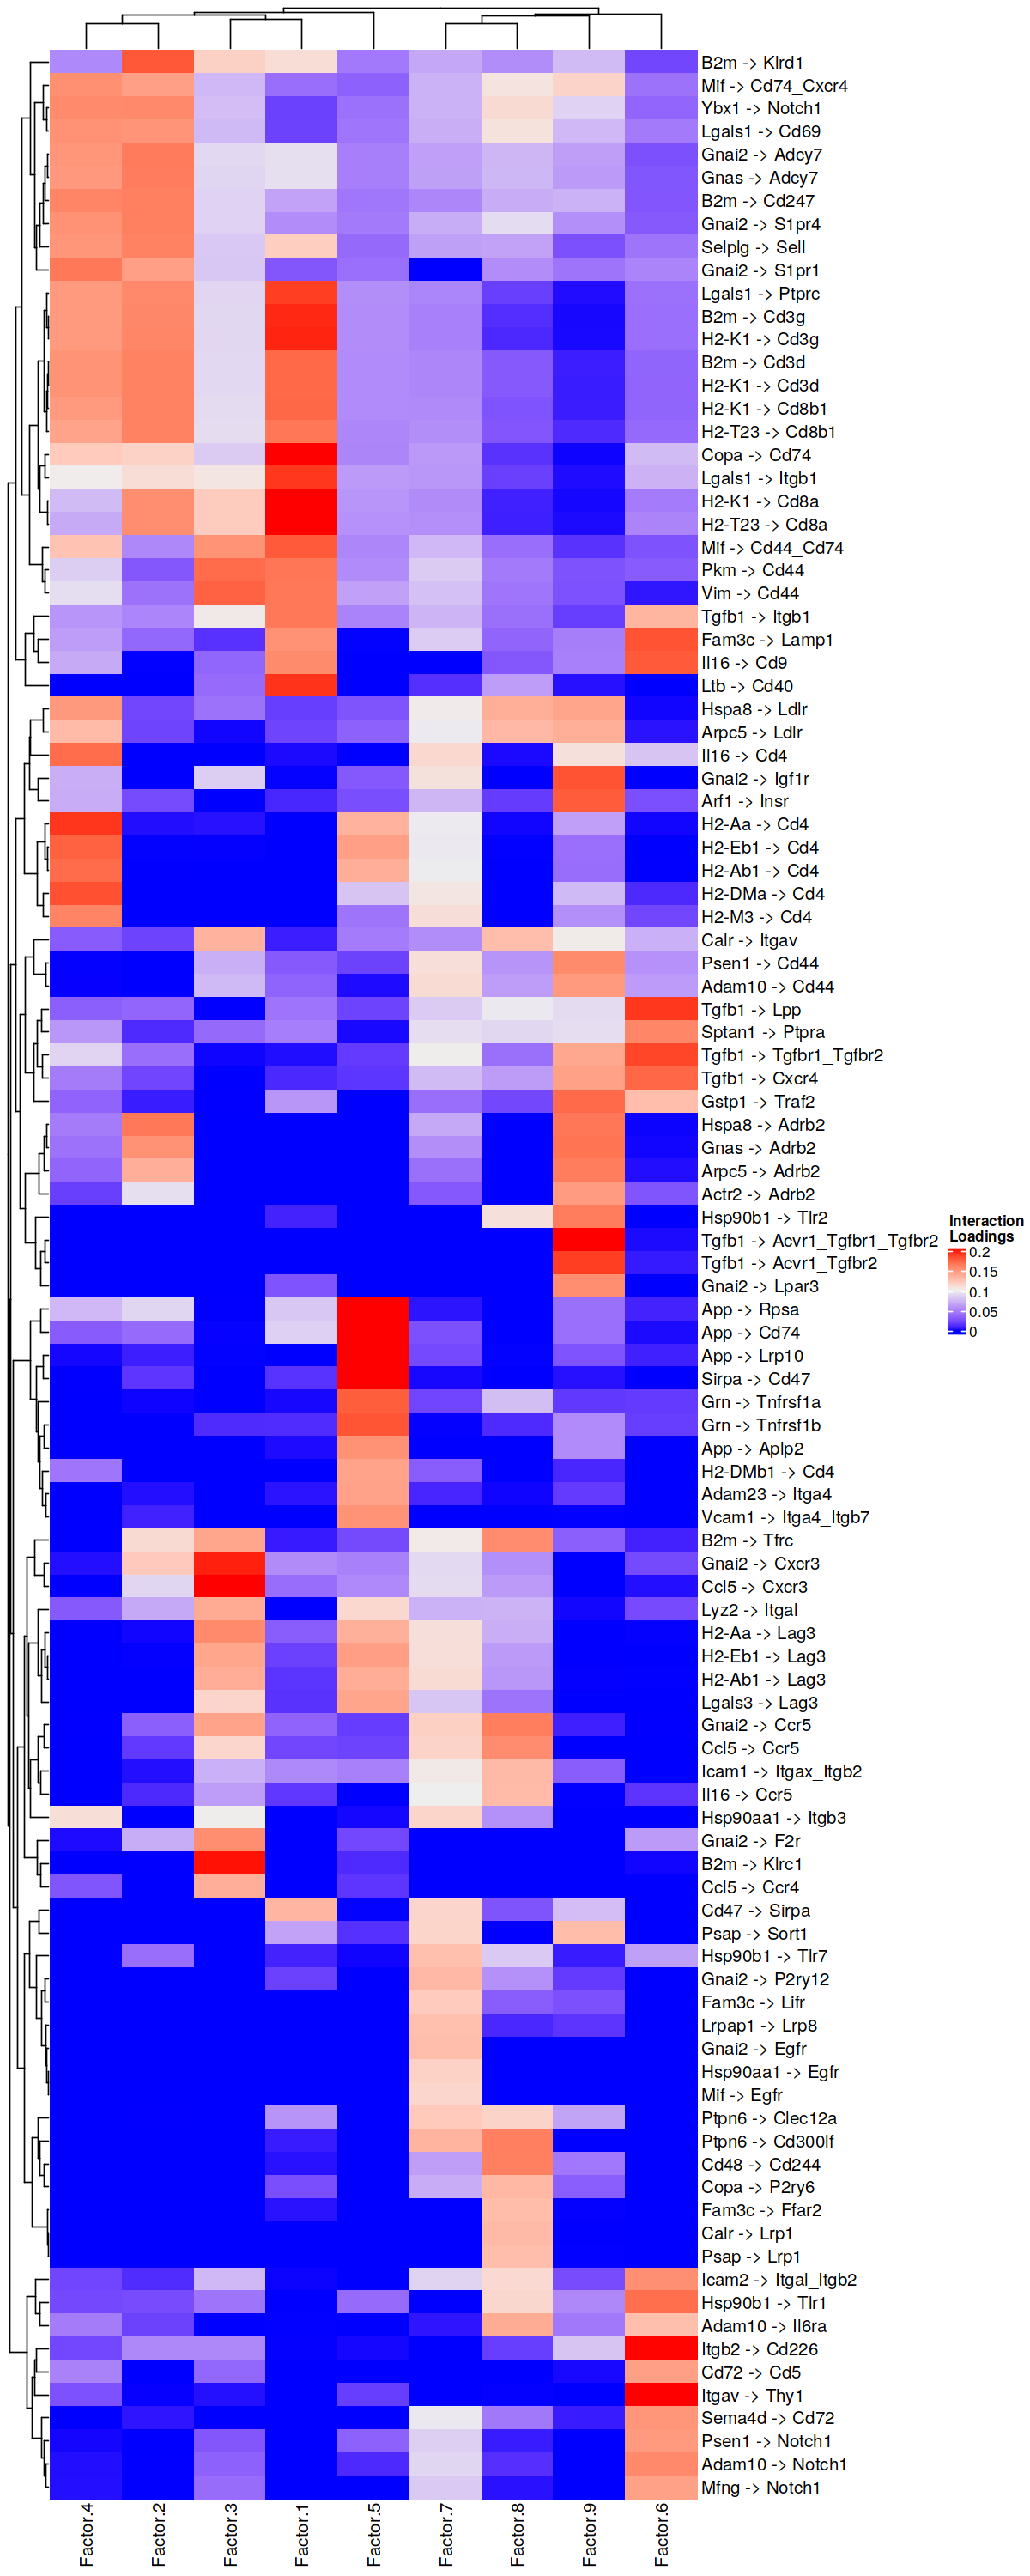

In [23]:
h_ = 25
w_ = 10
n_lrs<-15#5
options(repr.plot.height=h_, repr.plot.width=w_)
liana::plot_lr_heatmap(sce = abc.ccc.sce,  n = n_lrs)

In [24]:
top_lrs = list()
for (factor.name in paste0('Factor ', fos)){
    top_lrs[[factor.name]] = tensor$get_top_factor_elements(order_name='interactions', 
                                factor_name=factor.name, 
                                top_number=as.integer(n_lrs))
}
top_lrs


$`Factor 3`
   Ccl5^Cxcr3     B2m^Klrc1   Gnai2^Cxcr3      Vim^Cd44      Pkm^Cd44 
    0.2039229     0.2007087     0.1986094     0.1773518     0.1728444 
   H2-Aa^Lag3     Gnai2^F2r Mif^Cd44_Cd74    Gnai2^Ccr5   H2-Eb1^Lag3 
    0.1580753     0.1556377     0.1534079     0.1443791     0.1430090 
     B2m^Tfrc    Lyz2^Itgal   H2-Ab1^Lag3     Ccl5^Ccr4    Calr^Itgav 
    0.1428045     0.1404022     0.1387644     0.1377606     0.1353085 

$`Factor 8`
       Gnai2^Ccr5     Ptpn6^Cd300lf        Cd48^Cd244         Ccl5^Ccr5 
        0.1643898         0.1635698         0.1630565         0.1567327 
         B2m^Tfrc      Adam10^Il6ra        Hspa8^Ldlr        Copa^P2ry6 
        0.1567075         0.1393621         0.1382811         0.1325416 
       Arpc5^Ldlr Icam1^Itgax_Itgb2         Calr^Lrp1         Il16^Ccr5 
        0.1324826         0.1316305         0.1315347         0.1311606 
      Fam3c^Ffar2         Psap^Lrp1        Calr^Itgav 
        0.1299237         0.1291485         0.1290568 

$`Factor 9`
Tgfb1^Acvr1_Tgfbr1_Tgfbr2        Tgfb1^Acvr1_Tgfbr2               Gnai2^Igf1r 
                0.2195659                 0.1913889                 0.1836727 
                Arf1^Insr               Gstp1^Traf2                Gnas^Adrb2 
                0.1800842                 0.1735837                 0.1687490 
              Hspa8^Adrb2               Arpc5^Adrb2              Hsp90b1^Tlr2 
                0.1674912                 0.1651395                 0.1648572 
               Psen1^Cd44               Gnai2^Lpar3               Adam10^Cd44 
                0.1575894                 0.1557857                 0.1493177 
              Actr2^Adrb2               Tgfb1^Cxcr4                Hspa8^Ldlr 
                0.1489623                 0.1455712                 0.1431935

For each factor of interest, let's look at how the senders are interacting with teh receivers in more detail:

In [25]:
cc_plots<-list()
for (selected_factor in paste0('Factor.', fos)){
    cc_plots[[selected_factor]]<-liana::plot_c2c_cells(sce = abc.ccc.sce,
                                   factor_of_int = selected_factor,
                                    name = paste0(selected_factor, '\n', 
                                                 "Loadings Product"))    
}

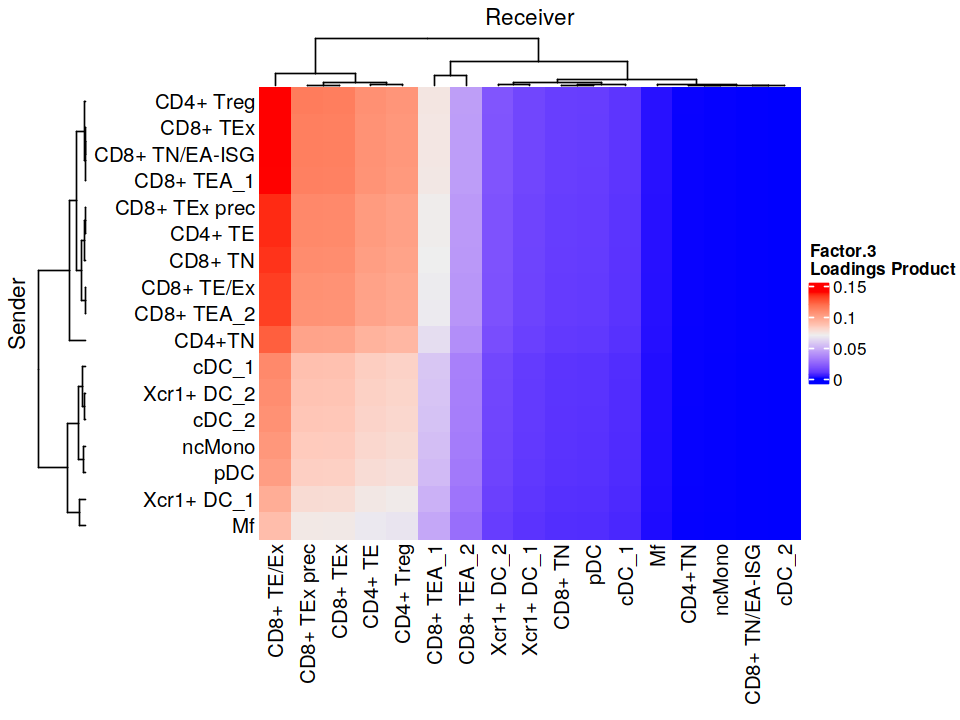

In [26]:
h_ = 6
w_ = 8
options(repr.plot.height=h_, repr.plot.width=w_)
i<-1
cc_plots[[i]]
i<-i+1

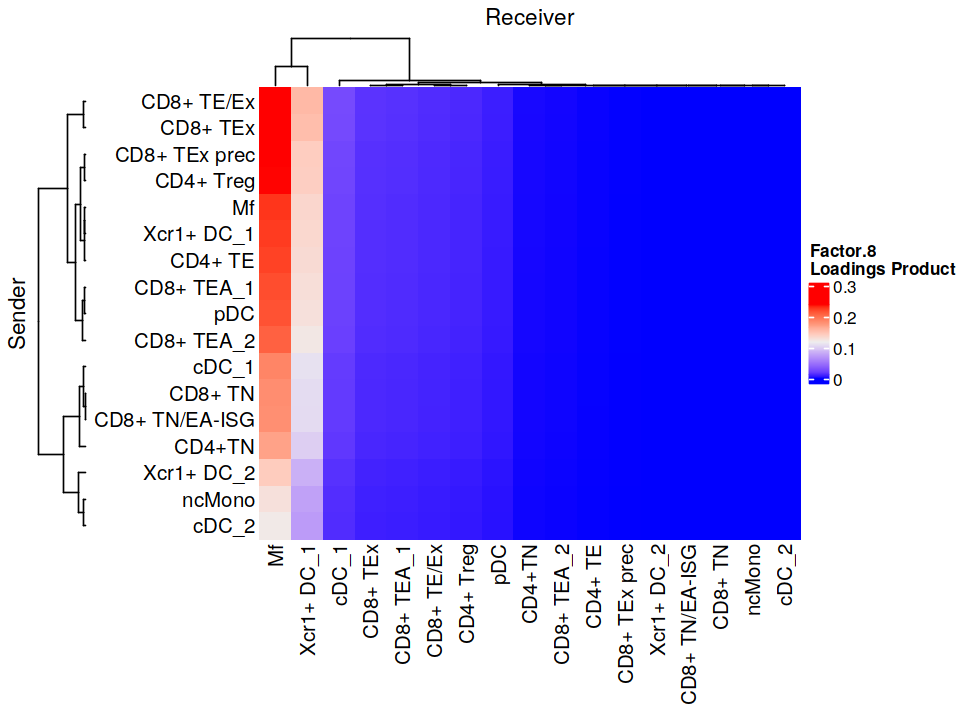

In [27]:
cc_plots[[i]]
i<-i+1

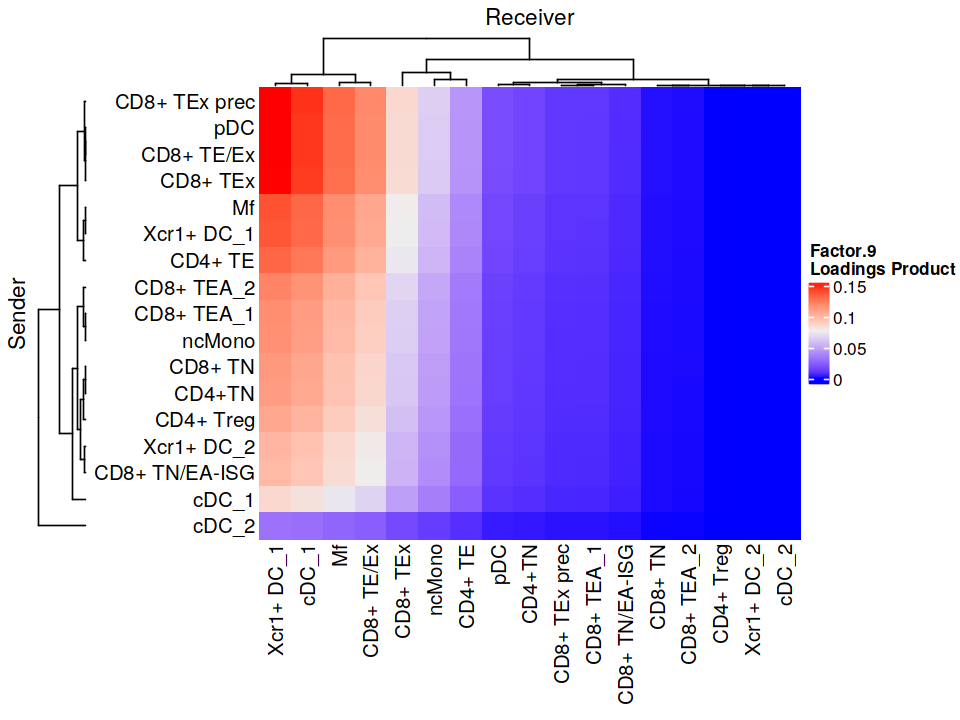

In [28]:
cc_plots[[i]]
i<-i+1

Let's take a look at the relationship between cell-cell and ligand receptor interactions:

In [29]:
get_joint_loadings<-function(tensor, selected_factor, dim1 = 'senders', dim2 = 'receivers'){
    
    v1<-tensor$factors[[dim1]][[selected_factor]]
    names(v1)<-rownames(tensor$factors[[dim1]])

    v2<-tensor$factors[[dim2]][[selected_factor]]
    names(v2)<-rownames(tensor$factors[[dim2]])
    
    return(outer(v1, v2, "*"))
}

get_lr_by_cell_pairs<-function(tensor, selected_factor, n_cci = NULL, n_lrs = NULL){
    sr<-get_joint_loadings(tensor, selected_factor, dim1 = 'senders', dim2 = 'receivers')
    
    # flatten
    sr<-as.vector(sr)
    element.names<-expand.grid(rownames(tensor$factors$senders), rownames(tensor$factors$receivers))
    element.names<-paste0(element.names[[1]], '->', element.names[[2]])
    names(sr)<-element.names
    
    if (!is.null(n_cci)){
#         sr<-sr[sr > cci_threshold]
        sr<-sort(sr, decreasing = T)[1:n_cci]
    }
    
    # get outer with lr
    v2<-tensor$factors$interactions[[selected_factor]]
    names(v2)<-rownames(tensor$factors$interactions) 
    if (!is.null(n_lrs)){
        v2<-sort(v2, decreasing = T)[1:n_lrs]
    }

    mat<-outer(sr, v2, "*")
    
    return(t(mat))
}

In [30]:
lr_cc_list<-list()
for (selected_factor in paste0('Factor ', fos)){
    mat<-get_lr_by_cell_pairs(tensor, selected_factor, n_cci = 30, n_lrs = 30)
    write.csv(mat, paste0(data_path, 'interim/', 'Factor', selected_factor, '_lr_by_cell.csv'))
    lr_cc_list[[selected_factor]]<-ComplexHeatmap::Heatmap(mat, 
                                                   name = paste0(selected_factor), 
                                                   column_title = "lr", row_title = 'cci')
}

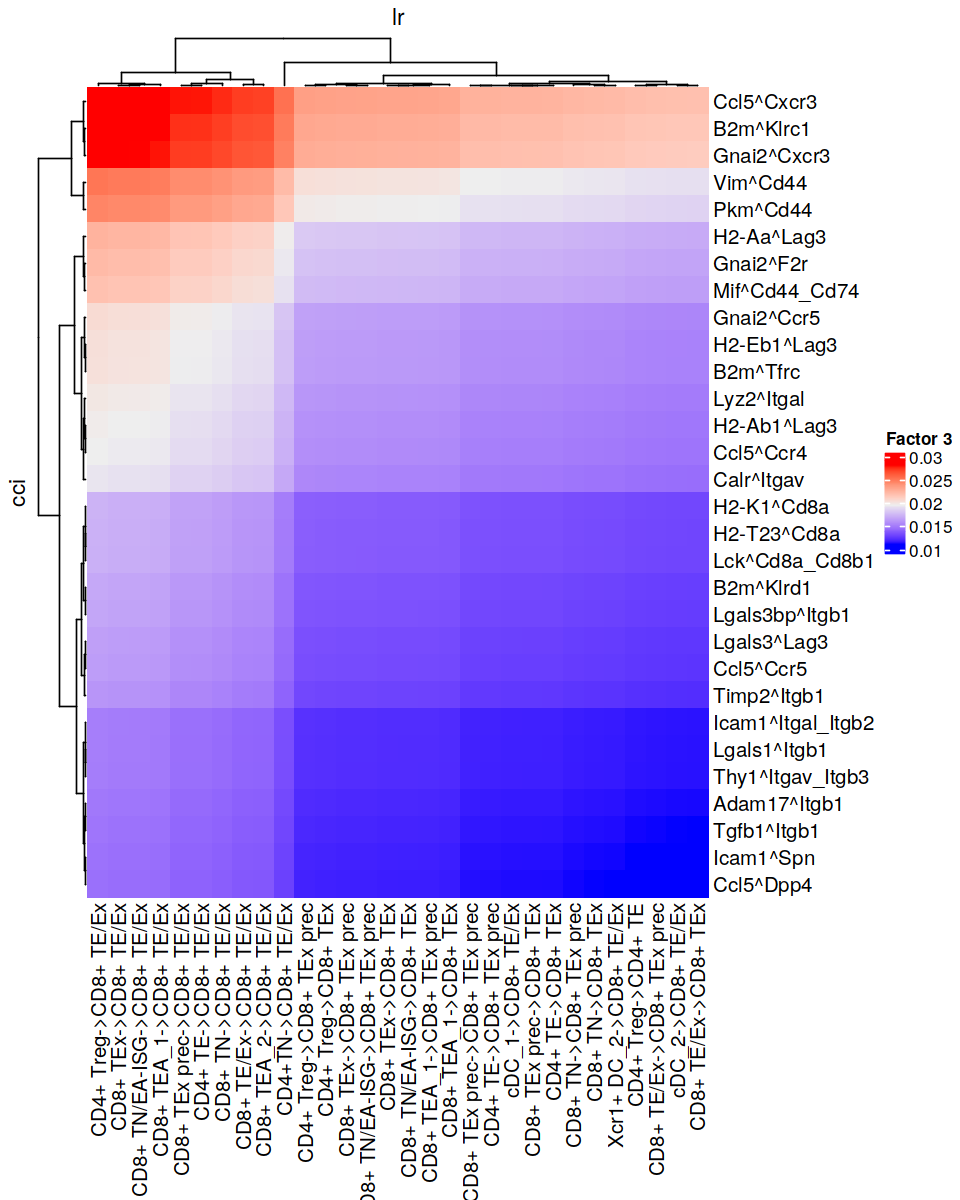

In [31]:
h_ = 10
w_ = 8
options(repr.plot.height=h_, repr.plot.width=w_)

i<-1
lr_cc_list[[i]]

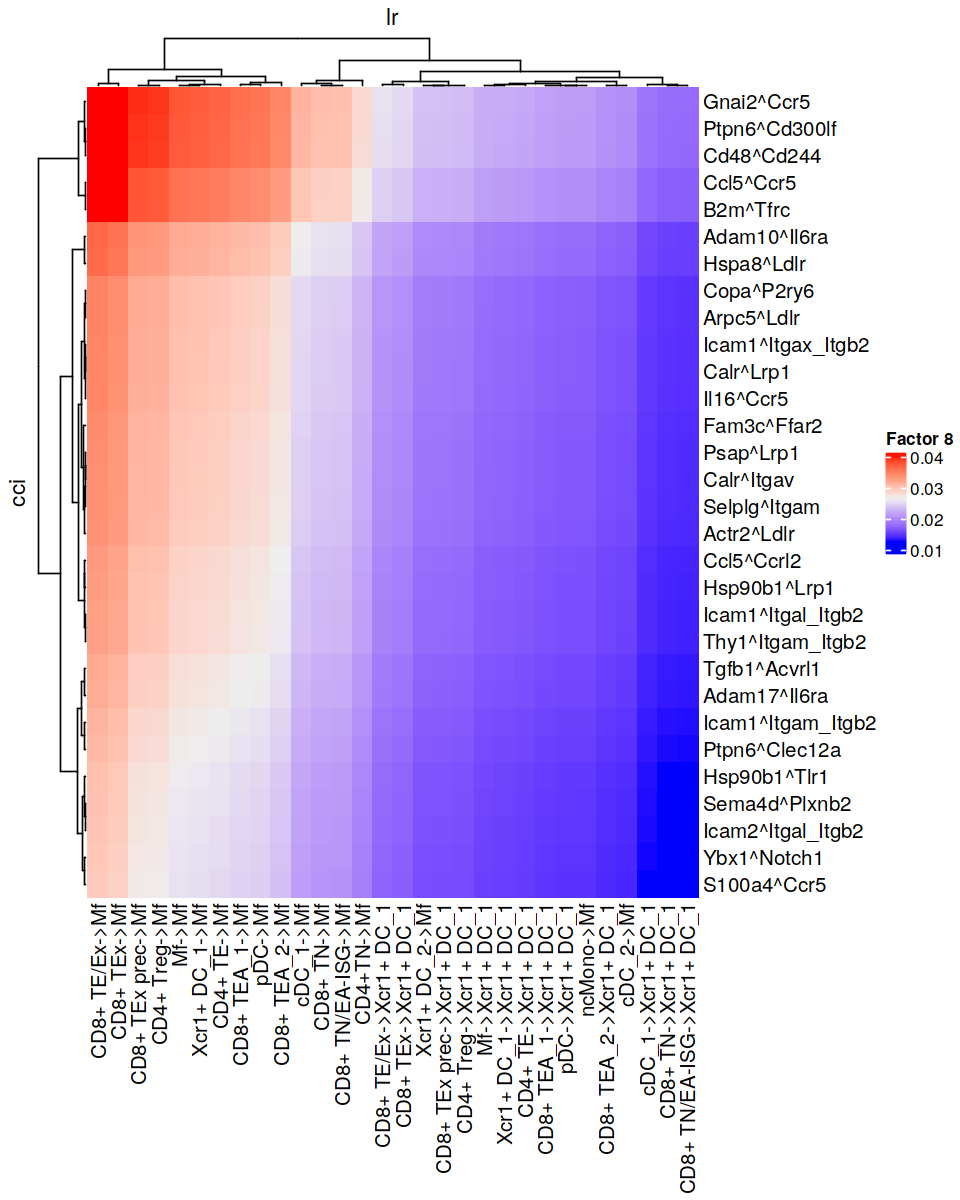

In [32]:
i<-i+1
lr_cc_list[[i]]

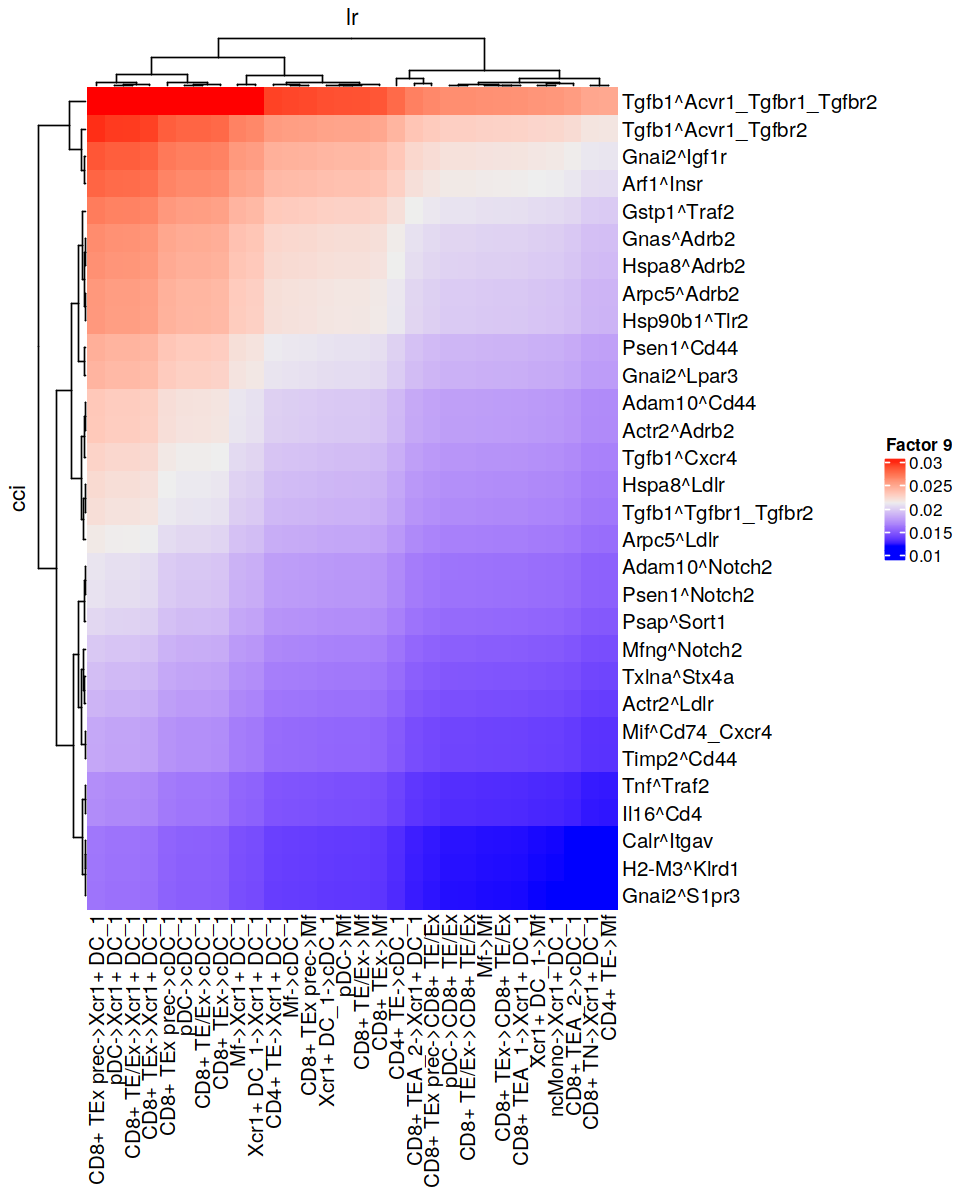

In [33]:
i<-i+1
lr_cc_list[[i]]

<span style="color:red">**Enrichment analysis must be refined a lot once specific factors are decided**

Finally, let's do an enrichment of the LRs for each of the context-specific Factors:

In [21]:
organism = 'mouse' 
pathwaydb = 'GOBP' # KEGG# can't use KEGG with mouse, may want to map ortholog

# lr_pairs <- liana::select_resource('Consensus')
# lr_pairs <- lr_pairs$Consensus[c('source_genesymbol', 'target_genesymbol')]
lr_pairs <- ortholog_resource[c('source_genesymbol', 'target_genesymbol')]
names(lr_pairs) <- c('ligand', 'receptor')
lr_list <- apply(lr_pairs, 1, function(x) paste0(x[[1]], '^', x[[2]]))
                 
lr_set <- c2c$external$generate_lr_geneset(lr_list = lr_list, 
                        complex_sep='_', # Separation symbol of the genes in the protein complex
                          lr_sep='^', # Separation symbol between a ligand and a receptor complex
                          organism=organism,
                          pathwaydb=pathwaydb,
                          readable_name=TRUE)    
lr_loadings = factors[['interactions']] %>% 
                column_to_rownames("lr")

In [35]:
gsea_res <- c2c$external$run_gsea(loadings=lr_loadings, 
                               lr_set=lr_set,
                               output_folder=paste0(data_path, 'interim/')
                              )
names(gsea_res)<-c('pvals', 'scores', 'gsea_df')

In [36]:
gsea.dotplot<-function(pval_df, score_df, significance = 0.05, font_size = 15){
    pval_df <- pval_df[apply(pval_df<significance,1,any), apply(pval_df<significance, 2, any)] %>% 
            mutate_all(function(x) -1*log10(x + 1e-9))
    score_df <- score_df[rownames(pval_df), colnames(pval_df)]
    pval_df <- pval_df %>%
                    tibble::rownames_to_column('Annotation')
    score_df <- score_df %>%
                    tibble::rownames_to_column('Annotation')

    viz_df <- cbind(melt(pval_df), melt(score_df)[[3]])
    names(viz_df) <- c('Annotation', 'Factor', 'Significance', 'NES')
    
                       
    dotplot <- ggplot(viz_df, aes(x = Factor, y = Annotation)) + geom_point(aes(size = Significance, color = NES)) + 
                scale_color_gradient2() + theme_bw(base_size = font_size) + 
                theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5))+
                       scale_size(range = c(0, 8)) + 
                       guides(size=guide_legend(title="-log10(p-value)"))
    return(dotplot)
}

No significant hits...

In [38]:
min(min(gsea_res$pvals))

[1] 0.1050651

In [40]:
h_ = 8
w_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)

dotplot <- gsea.dotplot(pval_df = gsea_res$pvals, 
                       score_df = gsea_res$scores, 
                       significance = 0.05)
dotplot

## ORA 

<font color='red'>**Running through metascape may introduce biases (since converting from LR --> gene list doesn't account for repeating receptors (e.g., L1-R1, L2-R1, L3-R1). It is better to convert gene pathway databases to LRs as done by c2c.external.generate_lr_geneset. Thus, will run ORA using clusterProfiler on the output of that function AND will conver the lr inputs for metascape.**</font> 


### ORA Clusterprofiler

ORA using clusterprofiler, with pathways mapped to LR pairs rather than genes as in c2c.external.generate_lr_geneset:

In [542]:
# p.adjust = BH corrected -- # https://github.com/YuLab-SMU/clusterProfiler/issues/124
# GeneRatio -- ratio of input genes in specific pathway vs input genes in all pathways https://www.biostars.org/p/220465/

# can improve visualization by directly manipulating the @result of each output
# if doing this, change qvalueCutoff to 1 and directly filter

visualize_ora<-function(cp.out, factor.name, sig.thresh = 0.1, top_n_terms = 10){
    viz.df<-cp.out@result
    viz.df[['significant']]<-paste0('fdr > ', sig.thresh)
    viz.df[viz.df$p.adjust <= sig.thresh, 'significant']<-paste0('fdr', ' \u2264 ',  sig.thresh)

    viz.df[['significant']]<-factor(viz.df[['significant']], 
                                    levels = c(paste0('fdr', ' \u2264 ',  sig.thresh), paste0('fdr > ', sig.thresh)))
    viz.df[['log.fdr']]<- -log10(viz.df$p.adjust)
    viz.df[['GeneRatio2']]<-unlist(unname(sapply(viz.df$GeneRatio, function(x) eval(parse(text=x)))))

    viz.df<-viz.df[with(viz.df, order(significant, -GeneRatio2, -log.fdr, -Count)), ]

    viz.df<-viz.df[1:top_n_terms, ]
    viz.df[['ID']]<-factor(viz.df[['ID']], 
                                    levels = rev(viz.df[['ID']]))

    green_hex = brewer.pal(n = 11, name ='RdYlGn')[[11]]
    yellow_hex = brewer.pal(n = 11, name = 'RdYlGn')[[6]]
    red_hex = brewer.pal(n = 11, name = 'RdYlGn')[[1]]

    lower_q = min(viz.df$log.fdr[!(is.na(viz.df$log.fdr))])
    upper_q = max(viz.df$log.fdr[!(is.na(viz.df$log.fdr))])
    middle_q = mean(c(lower_q, upper_q))#median(viz.df$log.fdr[!(is.na(viz.df$log.fdr))]) 
    # middle_q = 7.5

    g<-ggplot(data = viz.df, aes(x = GeneRatio2, y = ID, color = log.fdr, size = Count, shape = significant)) + 
    geom_point() + 
    ylab('') + xlab('GeneRatio') + ggtitle(factor.name) +
#     scale_color_gradient2(low = green_hex, mid = yellow_hex, high = red_hex, name = '-log10(fdr)', 
#                          limits = c(lower_q, upper_q), midpoint = middle_q) + 
    scale_colour_gradientn(colours = rev(c("darkred", "orange", "yellow")), name = '-log10(fdr)')+
    scale_shape_manual(values = c(16,4), drop = FALSE)+
    scale_size_continuous(range = c(4,12))+
    theme_bw() + theme(#axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), 
                      text = element_text(size = 15), plot.title = element_text(hjust = 0.5))


    return(g)
}

In [543]:
# prep input
keys<-names(lr_set)

lr_set_R<-list()
for (key in keys){
    lr_set_R[[key]]<-reticulate::iterate(reticulate::as_iterator(lr_set[key]))
} 

ora_db<-stack(lr_set_R)
ora_db<-ora_db[c(2,1)]
names(ora_db)<-c('Pathway', 'LR_Pair')

Run with setting background to the entire LIANA database that mapped to pathways:

In [544]:
# run ORA on top LRs per factor
frac_top = 0.1 # get the top n% of LRs per factor
n_lrs_top<-round(frac_top*dim(factors$interactions)[[1]])

ora_res<-list()
for (factor.name in paste0('Factor ', 1:tensor$rank)){
    factor_lrs<-names(tensor$get_top_factor_elements(order_name='interactions', 
                                factor_name=factor.name, 
                                top_number=as.integer(n_lrs_top)))
    
    if (length(setdiff(factor_lrs, lr_list)) > 0){
        stop('Unexpected LRs in loadings')
    }
    
    # if universe argument is not set, all the LRs in ora_db (which is all the LRs from the DB that mapped
    # to a pathway) will be used
    ora_res[[factor.name]]<-clusterProfiler::enricher(factor_lrs, TERM2GENE = ora_db, 
                                                     pAdjustMethod = 'BH', 
                                                      pvalueCutoff = 1, # will filter later
                                                      qvalueCutoff = 1 # will filter later
                                                     )
}

In [545]:
# visualize
dotplot_list<-c()
for (fn in names(ora_res)){
    cp.out<-ora_res[[fn]]
    g<-visualize_ora(cp.out, fn)
    
    dotplot_list[[fn]]<-g
    

}

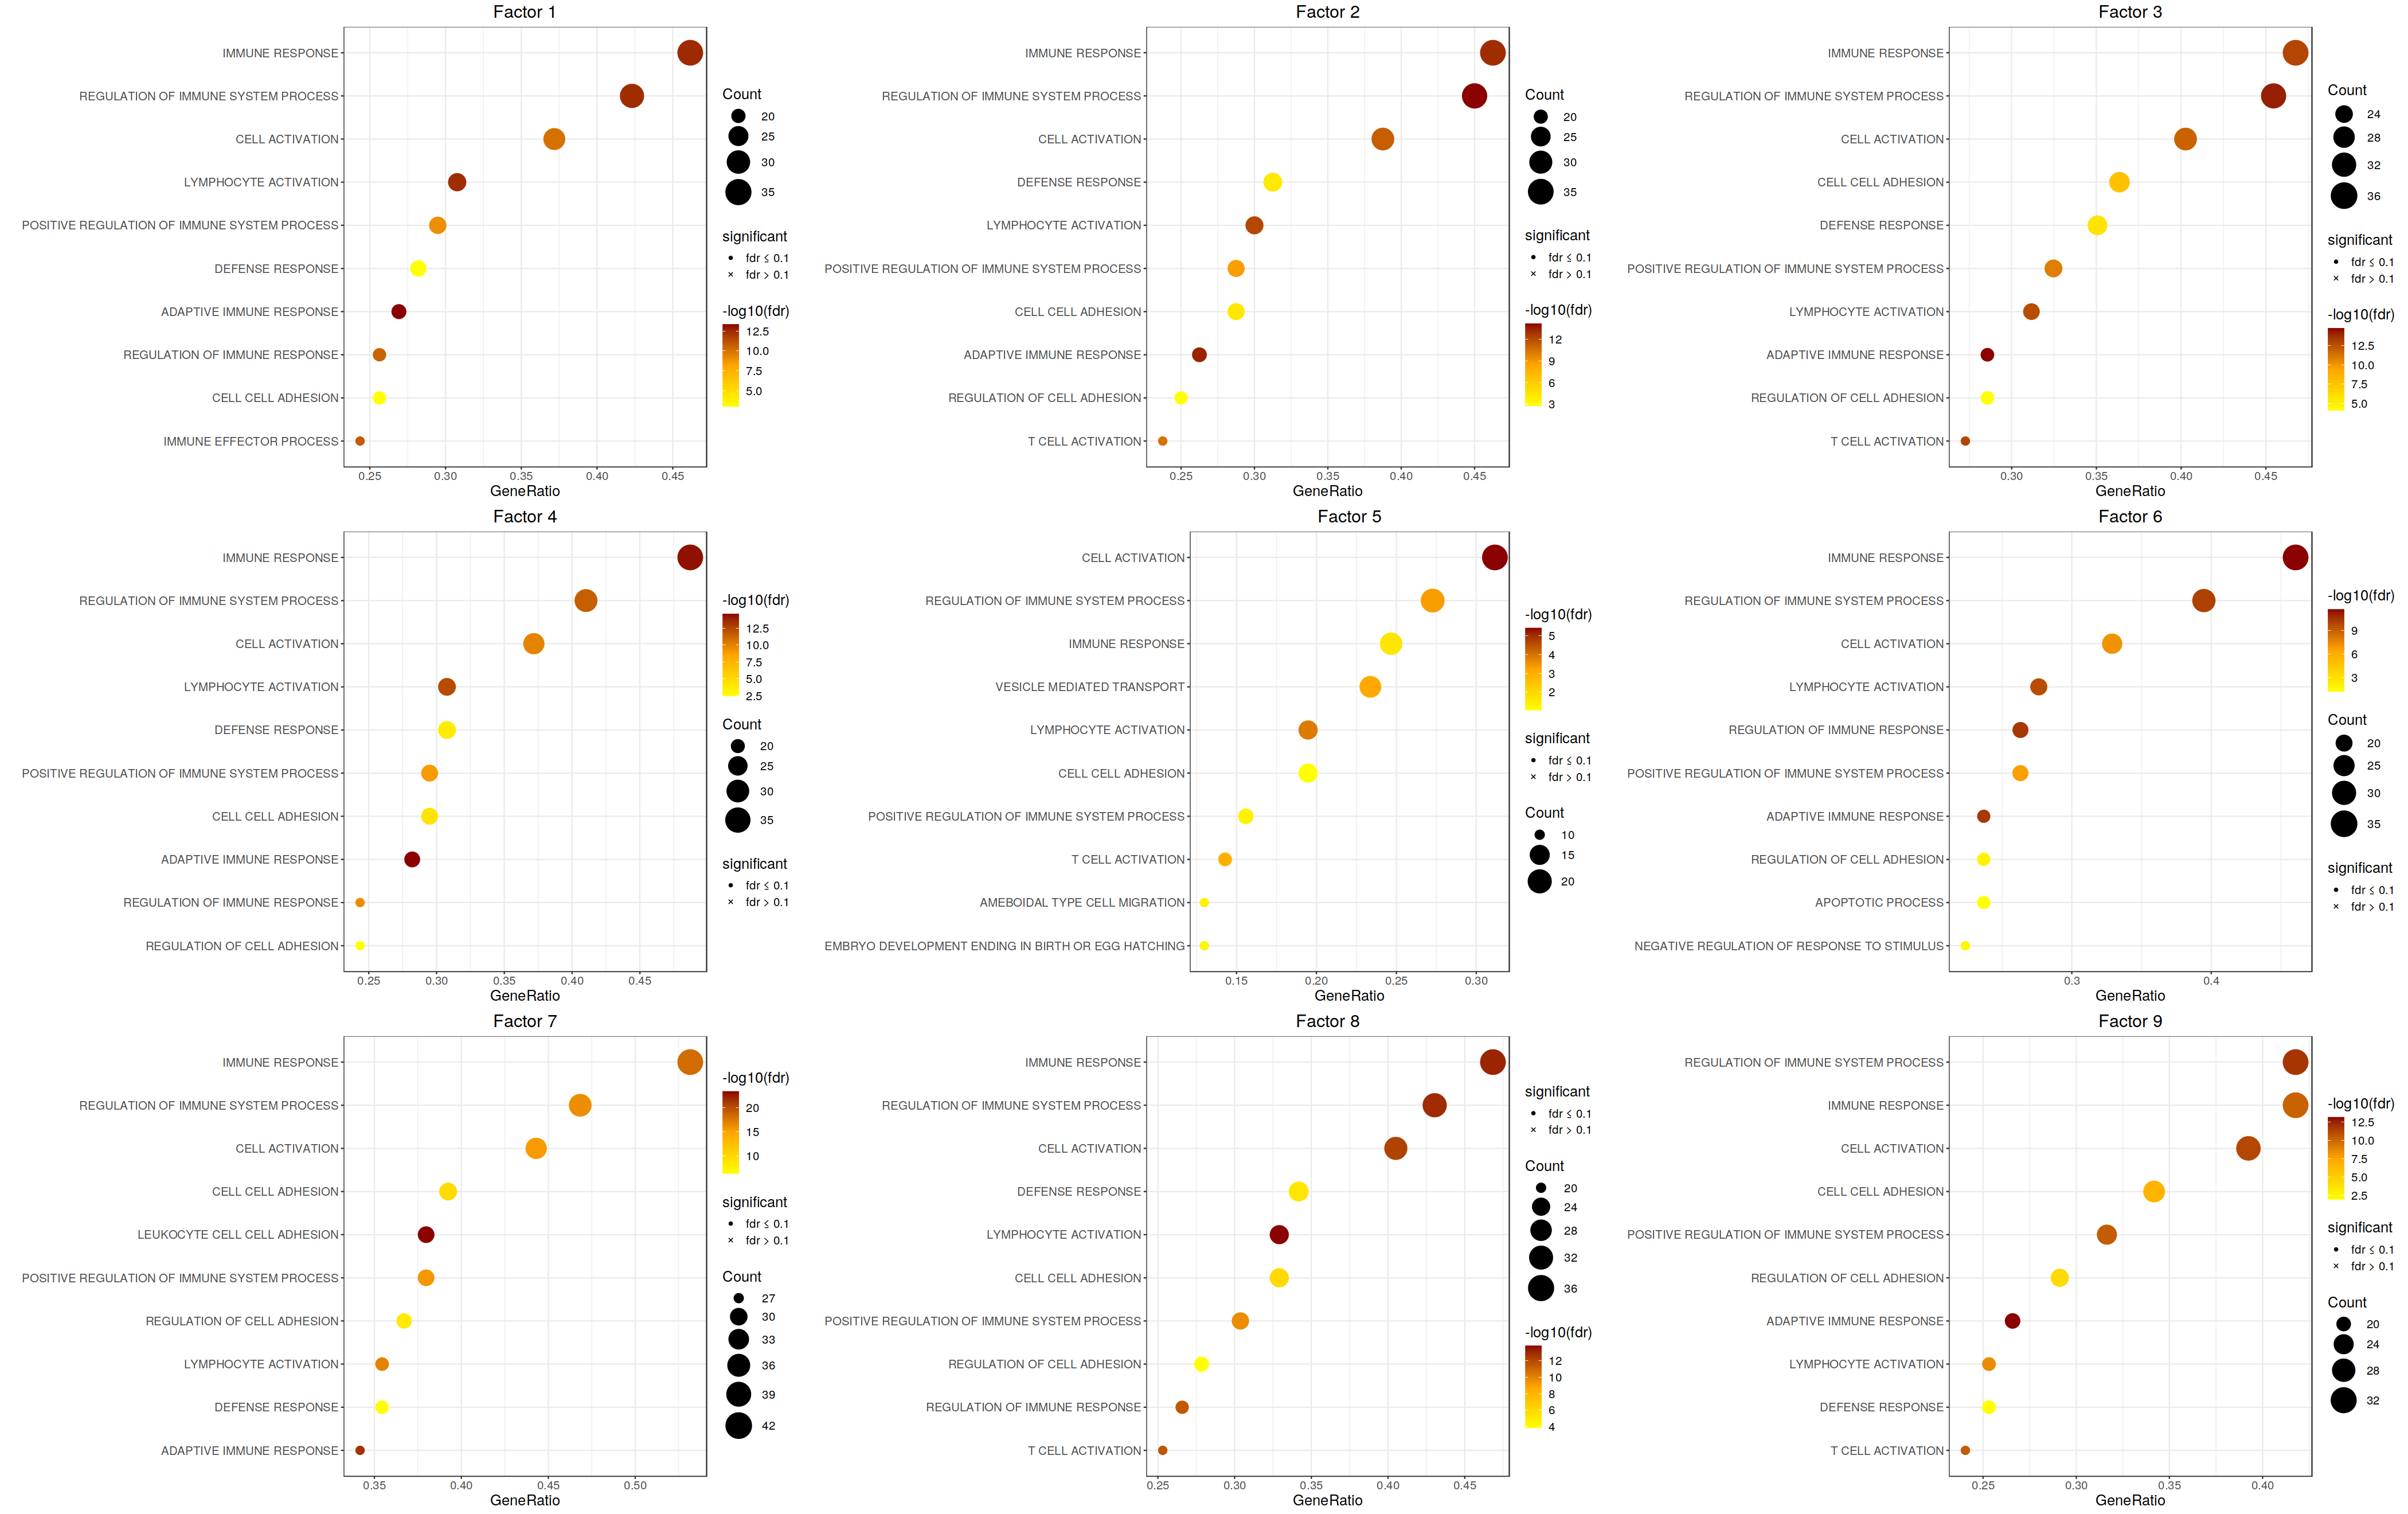

In [546]:
h_ = 22
w_ = 35
options(repr.plot.height=h_, repr.plot.width=w_)

suppressWarnings({
    g<-cowplot::plot_grid(dotplot_list[[1]], dotplot_list[[2]], dotplot_list[[3]], dotplot_list[[4]], dotplot_list[[5]], 
                   dotplot_list[[6]], dotplot_list[[7]], dotplot_list[[8]], dotplot_list[[9]],
                   ncol = 3)
})

g

Run with setting background only to final scored interctions:


In [547]:
# run ORA on top LRs per factor
frac_top = 0.1 # get the top n% of LRs per factor
n_lrs_top<-round(frac_top*dim(factors$interactions)[[1]])

ora_res_strict<-list()
for (factor.name in paste0('Factor ', 1:tensor$rank)){
    factor_lrs<-names(tensor$get_top_factor_elements(order_name='interactions', 
                                factor_name=factor.name, 
                                top_number=as.integer(n_lrs_top)))
    
    if (length(setdiff(factor_lrs, lr_list)) > 0){
        stop('Unexpected LRs in loadings')
    }
    
    # if universe argument is not set, all the LRs in ora_db (which is all the LRs from the DB that mapped
    # to a pathway) will be used
    
    # for now, set background to all SCORED lrs, which is a subset of ora_db
    ora_res_strict[[factor.name]]<-clusterProfiler::enricher(factor_lrs, TERM2GENE = ora_db, 
                                                      universe = rownames(tensor$factors$interactions), 
                                                     pAdjustMethod = 'BH', 
                                                      pvalueCutoff = 1, # will filter later
                                                      qvalueCutoff = 1 # will filter later
                                                     )
}

In [548]:
# visualize
dotplot_list_strict<-c()
for (fn in names(ora_res_strict)){
    cp.out<-ora_res_strict[[fn]]
    g<-visualize_ora(cp.out, fn)
    
    dotplot_list_strict[[fn]]<-g
    

}

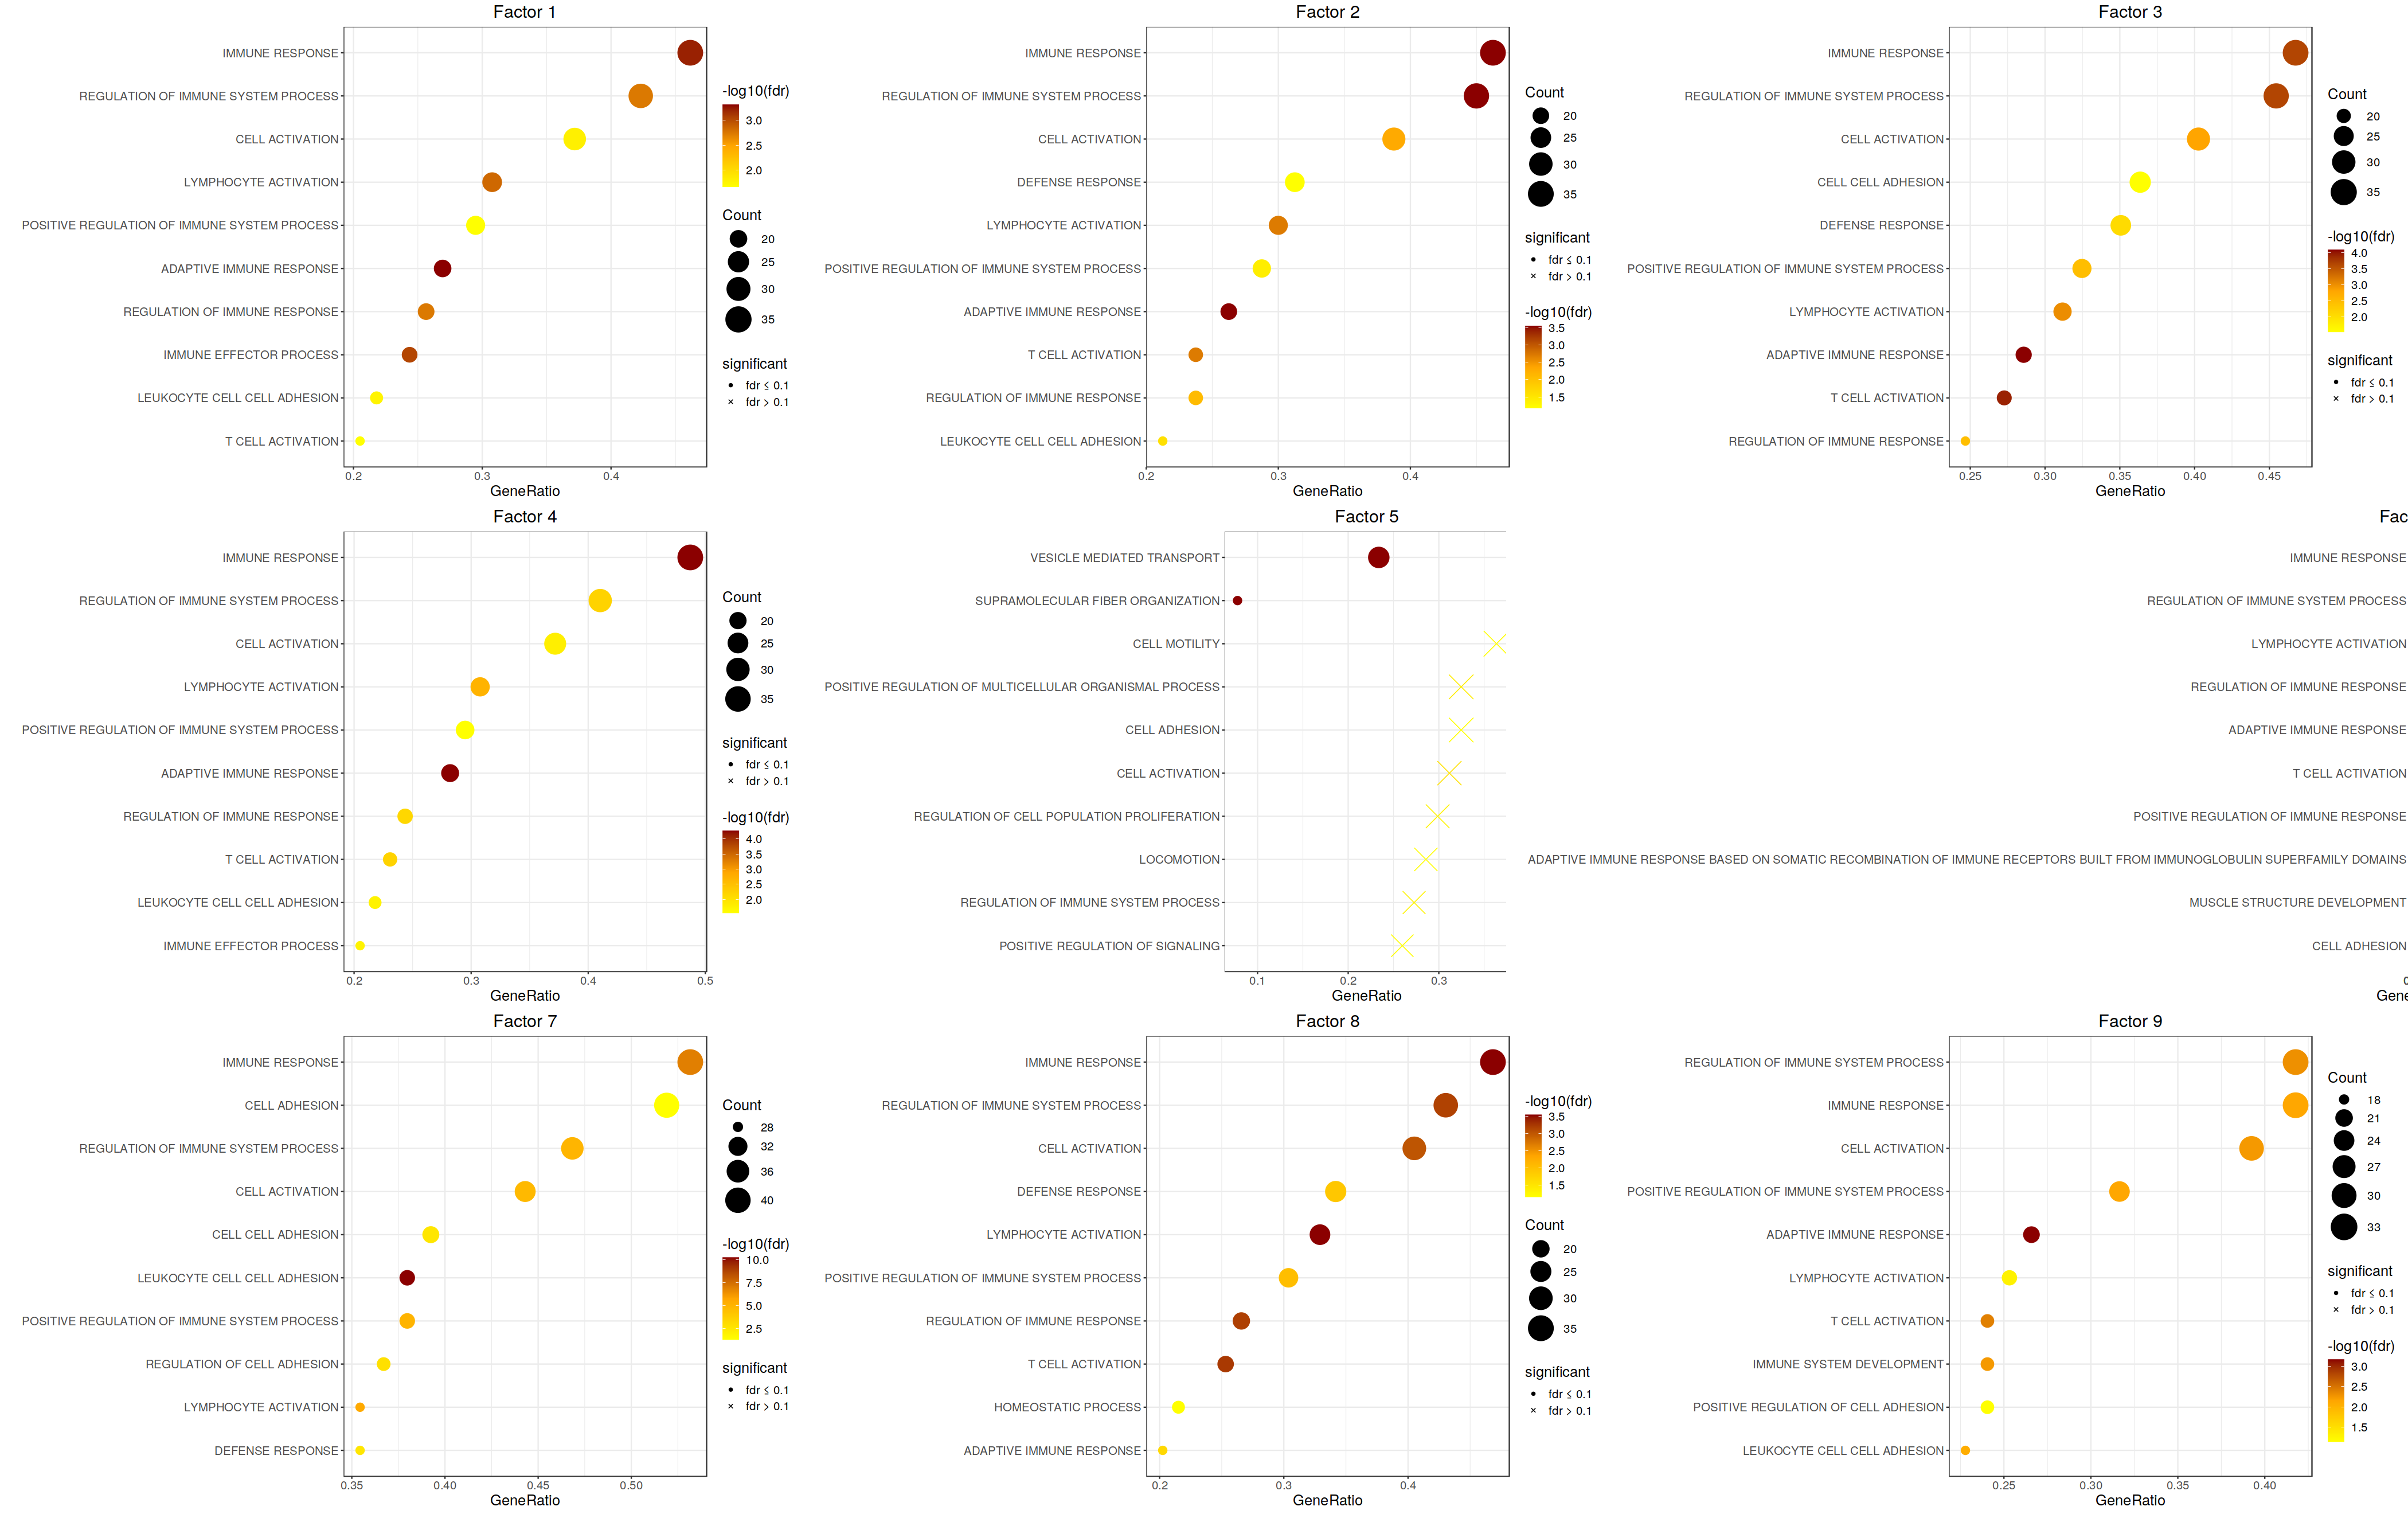

In [549]:
h_ = 22
w_ = 35
options(repr.plot.height=h_, repr.plot.width=w_)

suppressWarnings({
    g<-cowplot::plot_grid(dotplot_list_strict[[1]], dotplot_list_strict[[2]], dotplot_list_strict[[3]], dotplot_list_strict[[4]], dotplot_list_strict[[5]], 
                   dotplot_list_strict[[6]], dotplot_list_strict[[7]], dotplot_list_strict[[8]], dotplot_list_strict[[9]],
                   ncol = 3)
})

g

Note, neither background approach is perfect. The first includes LRs that may not even have been in the dataset, the second excludes LRs that may have been thresholded out. To get the real backgorund, would need to rerun with the least stringent thresholds. 


## ORA Metascape 

Prepping inputs for metascape. Will run the top 10% of scored LRs for each factor. Will use the background as all genes in the single-cell dataset that are present in the input CCC LR DB:

In [550]:
lr_pair_genes<-unique(c(lr_pairs$ligand, lr_pairs$receptor)) # lr_pairs is the full LR DB that liana was run on
lr_pair_genes<-unique(unlist(str_split(as.character(lr_pair_genes), '_'))) # complexes joined by _
dataset.genes<-rownames(abc.ccc@assays$RNA@data)

universe.background<-intersect(lr_pair_genes, dataset.genes) 

# get all teh scored lrs and convert LRs --> genes
scored_lrs<-unique(unlist(str_split(as.character(factors$interactions$lr), '\\^'))) # interactions joined by ^
scored_lrs<-unique(unlist(str_split(as.character(scored_lrs), '_'))) # complexes joined by _


cond1<-(length(scored_lrs) > length(lr_pair_genes))
cond2<-(length(setdiff(scored_lrs, lr_pair_genes)) > 0)
cond3<-(length(setdiff(scored_lrs, dataset.genes)) > 0)
if ((cond1) | (cond2) | (cond3)){
    stop('Unexpected difference in identified loadings and LR DB')
}

In [551]:
frac_top = 0.1 # get the top n% of LRs per factor
n_lrs_top<-round(frac_top*dim(factors$interactions)[[1]])

metascape_input = list()
# set background as all lr pairs from database that are present in sc dataset
metascape_input[['_BACKGROUND']]<-universe.background

for (factor.name in paste0('Factor ', 1:tensor$rank)){
    factor_lrs<-names(tensor$get_top_factor_elements(order_name='interactions', 
                                factor_name=factor.name, 
                                top_number=as.integer(n_lrs_top)))
    # LRs --> genes
    factor_genes<-unique(unlist(str_split(as.character(factor_lrs), '\\^'))) # LR interactions joined by ^
    factor_genes<-unique(unlist(str_split(as.character(factor_genes), '_'))) # complexes joined by _
    metascape_input[[factor.name]]<-factor_genes
}

# format input to metascape
max.length <- max(sapply(metascape_input, length))
metascape_input <- lapply(metascape_input, function(v) { c(v, rep(NA, max.length-length(v)))})
metascape_input<-do.call(cbind, metascape_input)
write.csv(metascape_input, paste0(data_path, 'interim/', 'lr_metascape_input_v2.csv'), row.names=FALSE)

Let's visualize the output:

In [552]:
format.ms<-function(ms, val_col){
    val_df<-as.data.frame(pivot_wider(data = ms, id_cols = 'GeneList', names_from = 'Description', 
                                      values_from = val_col, 
                                    values_fn = mean))
    val_df<-t(column_to_rownames(x = val_df, loc = 1))

    return(val_df)
}

In [553]:
ms.top20<-read.csv(paste0(data_path, 'interim/', 'lr_metascape_out_v2/Enrichment_heatmap/HeatmapSelectedGO.csv'))
ms.top100<-read.csv(paste0(data_path, 'interim/', 'lr_metascape_out_v2/Enrichment_heatmap/HeatmapSelectedGOTop100.csv'))
ms<-read.csv(paste0(data_path, 'interim/', 'lr_metascape_out_v2/Enrichment_GO/GO_AllLists.csv'))

First, let's see if there is any duplicate Description/GeneList combinations:

In [554]:
ms %>%
  dplyr::group_by(GeneList, Description) %>%
  dplyr::summarise(n = dplyr::n(), .groups = "drop") %>%
  dplyr::filter(n > 1L)

GeneList,Description,n
<chr>,<chr>,<int>
Factor 6,Notch signaling pathway,2
Factor 8,Notch signaling pathway,2
Factor 9,Notch signaling pathway,2


In [555]:
ms[(ms$Description == 'Notch signaling pathway') & (ms$GeneList %in% c('Factor 6', 'Factor 8', 'Factor 9')), ]

,Category,CategoryID,GO,Description,PARENT_GO,LogP,Enrichment,Z.score,X.TotalGeneInLibrary,X.GeneInGO,X.GeneInHitList,X.GeneInGOAndHitList,X.InGO,STDV..InGO,GeneID,Hits,Log.q.value.,GeneList
,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
1665,WikiPathways,27,WP29,Notch signaling pathway,,-2.9,4.4,4.2,1200,14,118,6,5.1,2.0,11491|17305|18128|19164|21926|59287,Adam17|Mfng|Notch1|Psen1|Tnf|Ncstn,-1.8,Factor 6
1808,GO Biological Processes,19,GO:0007219,Notch signaling pathway,19_GO:0050896 response to stimulus,-2.1,2.8,3.1,1200,25,118,7,5.9,2.2,11487|11491|18128|19164|21803|21813|59287,Adam10|Adam17|Notch1|Psen1|Tgfb1|Tgfbr2|Ncstn,-1.3,Factor 6
2306,GO Biological Processes,19,GO:0007219,Notch signaling pathway,19_GO:0050896 response to stimulus,-2.7,3.1,3.6,1200,25,122,8,6.6,2.2,11487|11491|18128|18129|19164|20085|21803|21813,Adam10|Adam17|Notch1|Notch2|Psen1|Rps19|Tgfb1|Tgfbr2,-1.6,Factor 8
2482,WikiPathways,27,WP29,Notch signaling pathway,,-2.0,3.5,3.2,1200,14,122,5,4.1,1.8,11491|17305|18128|18129|19164,Adam17|Mfng|Notch1|Notch2|Psen1,-1.2,Factor 8
2530,GO Biological Processes,19,GO:0007219,Notch signaling pathway,19_GO:0050896 response to stimulus,-4.1,3.9,5.0,1200,25,123,10,8.1,2.5,11487|11491|11820|13610|18128|18129|19164|21803|21813|59287,Adam10|Adam17|App|S1pr3|Notch1|Notch2|Psen1|Tgfb1|Tgfbr2|Ncstn,-2.6,Factor 9
2550,WikiPathways,27,WP29,Notch signaling pathway,,-3.7,4.9,4.9,1200,14,123,7,5.7,2.1,11491|17305|18128|18129|19164|21926|59287,Adam17|Mfng|Notch1|Notch2|Psen1|Tnf|Ncstn,-2.3,Factor 9


In [556]:
'Notch signaling pathway' %in% ms.top100$Description

[1] TRUE

Looks l ike there is one term that is repeated , Notch signaling pathway. However, this term's values are quite similar for a given factor. So, we aggregate by the average in this case. 

In [559]:
freq<-format.ms(ms = ms, val_col = 'X.InGO')[ms.top20$Description, paste0('Factor ', 1:tensor$rank)]
pvals<-format.ms(ms = ms, val_col = 'Log.q.value.')[ms.top20$Description, paste0('Factor ', 1:tensor$rank)]

pvals<-as.data.frame(pvals)
pvals[['Enrichment.Term']]<-rownames(pvals)
freq<-as.data.frame(freq)
freq[['Enrichment.Term']]<-rownames(freq)

pvals<-melt(pvals, id.vars = 'Enrichment.Term', value.name = 'log10p', variable.name = 'Condition')
freq<-melt(freq, id.vars = 'Enrichment.Term', value.name = 'Frequency', variable.name = 'Condition')
pvals[['log10p']] <- -as.numeric(pvals[['log10p']]) 

viz.df <- cbind(pvals, Frequency = as.numeric(freq$Frequency))

Warning message:
“Removed 25 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 25 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 25 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 25 rows containing missing values (`geom_point()`).”


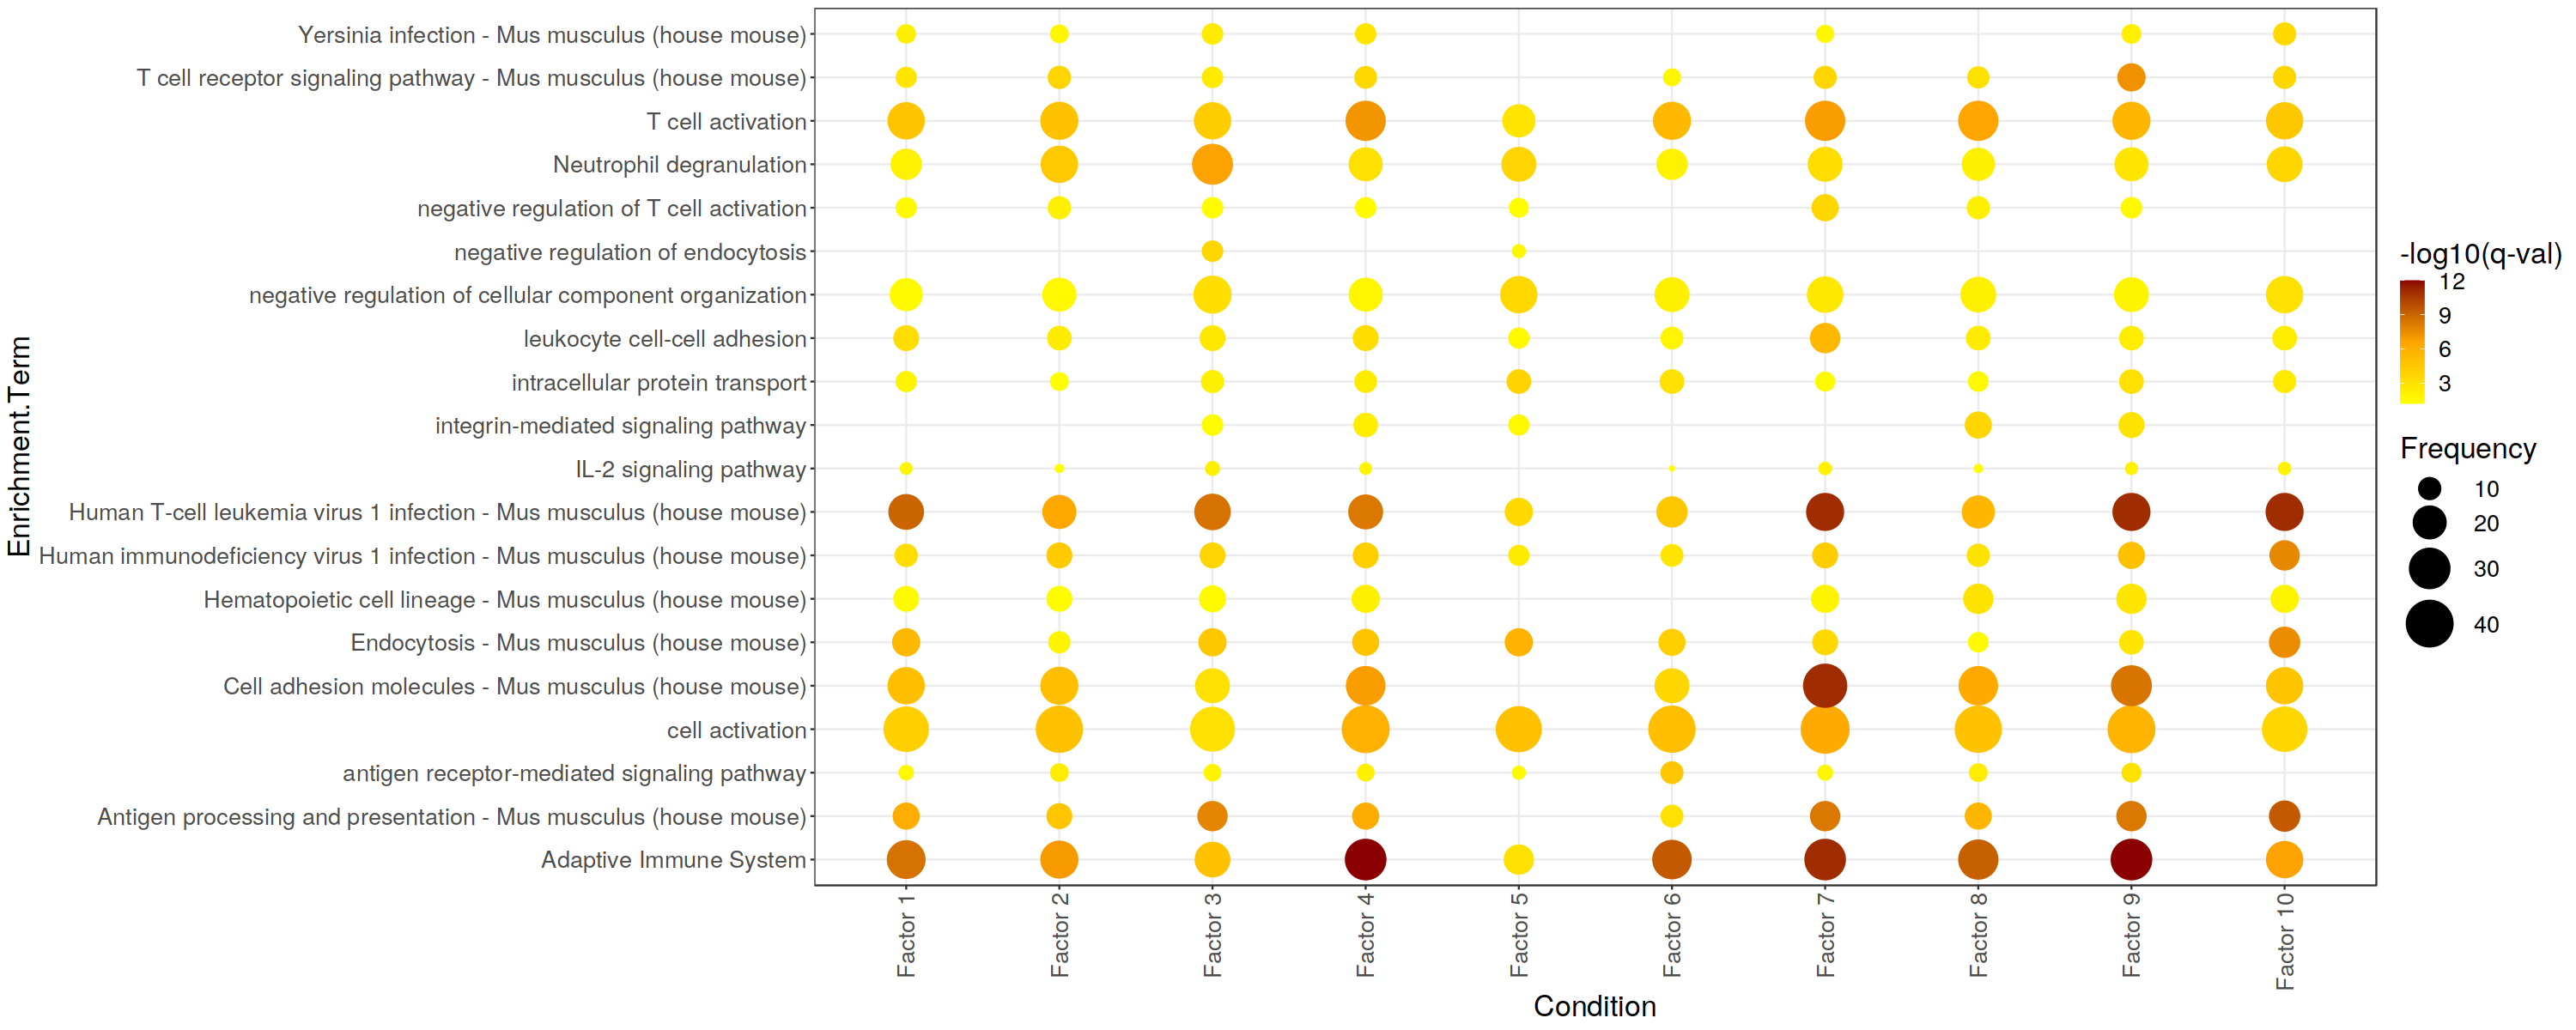

In [558]:
h_ = 10
w_ = 25
options(repr.plot.height=h_, repr.plot.width=w_)

green_hex = brewer.pal(n = 11, name ='RdYlGn')[[11]]
yellow_hex = brewer.pal(n = 11, name = 'RdYlGn')[[6]]
red_hex = brewer.pal(n = 11, name = 'RdYlGn')[[1]]

lower_q = min(viz.df$log10p[!(is.na(viz.df$log10p))])
upper_q = max(viz.df$log10p[!(is.na(viz.df$log10p))])
middle_q = mean(c(lower_q, upper_q)) # median(viz.df$log10p[!(is.na(viz.df$log10p))]) # 
# middle_q = 7.5

g<-ggplot(data = viz.df, aes(x = Condition, y = Enrichment.Term, color = log10p, size = Frequency)) + 
geom_point() + 
# scale_color_gradient2(low = green_hex, mid = yellow_hex, high = red_hex, name = '-log10(q-val)', 
#                      limits = c(lower_q, upper_q), midpoint = middle_q) + 
scale_colour_gradientn(colours = rev(c("darkred", "orange", "yellow")), name = '-log10(q-val)')+
scale_size_continuous(range = c(1,15)) +
theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), 
                  text = element_text(size = 20))


for (ext in c('.svg', '.png', '.pdf')){
    fn<-paste0(data_path, 'figures/', 'lr_metascape_enrichment_dotplot', ext)
    ggsave(fn, g, height = h_, width = w_)}

g

Now get downstream enriched genes:

In [41]:
# obtain progeny gene sets
progeny <- decoupleR::get_progeny(organism = 'mouse', top=5000) %>%
    select(-p_value)

# convert to LR sets
progeny_lr <- generate_lr_geneset(sce = abc.ccc.sce,
                                  resource = progeny)

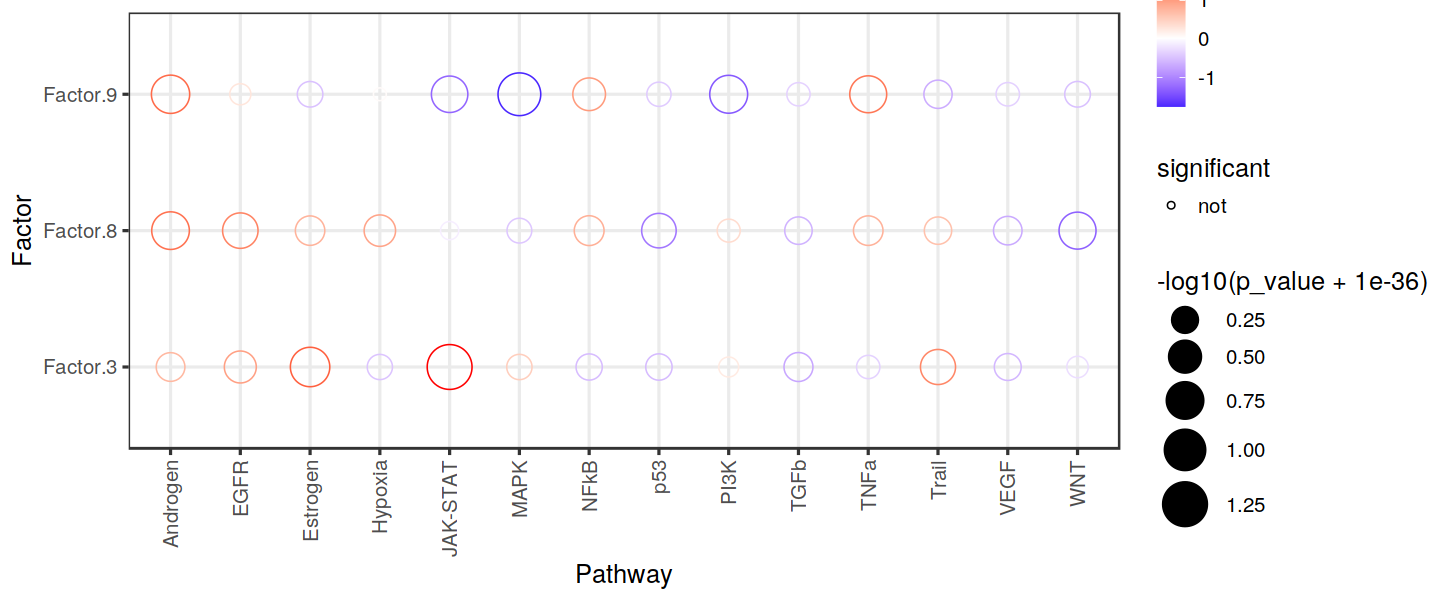

In [42]:
h_ = 5
w_ = 12
options(repr.plot.height=h_, repr.plot.width=w_)

# interaction loadings to matrix
mat <- factors$interactions[, c('lr', paste0('Factor.', fos))] %>%
    column_to_rownames("lr") %>%
  as.matrix()

# run enrichment analysis with decoupler
# (we fit a univariate linear model for each gene set)
# We don't consider genesets with minsize < 10
res <- decoupleR::run_ulm(mat = mat,
                          network = progeny_lr,
                          .source = "set",
                          .target = "lr",
                          minsize=10) %>%
  mutate(p_adj = p.adjust(p_value, method = "fdr"))

res %>% # sig/isnig flag
  mutate(significant = if_else(p_adj <= 0.1, "signif.", "not")) %>%
  ggplot(aes(x=source, y=condition, shape=significant,
             colour=score, size=-log10(p_value+1e-36))) +
  geom_point() +
  scale_colour_gradient2(high = "red", low="blue") +
  scale_size_continuous(range = c(3, 12)) +
  scale_shape_manual(values=c(21, 16)) +
  theme_bw(base_size = 15) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  labs(x="Pathway",
       y="Factor",
       colour="Activity"
       )

In [43]:
# progeny_lr[(progeny_lr$set == 'Estrogen') & (progeny_lr$mor > 0), ]

In [45]:
pathway = 'JAK-STAT'
factor = 'Factor.8'
# Plot LRs associated with Estrogen
lrs <-  factors$interactions %>%
  left_join(progeny_lr, by="lr") %>%
  filter(set==pathway) %>%
  select(lr, set, mor, loading = factor) %>%
  mutate(lr = gsub(as.character(str_glue("\\^")), " -> ", lr)) %>%
  mutate(weight = if_else(mor >= 0, "positive", "negative"))
lrs %>%
  # only label those that are > x
  mutate(lr = if_else(loading>=0.001 & abs(mor) > 2, lr, "")) %>%
  ggplot(aes(x=mor, y=loading, colour=weight)) +
  # label only top 20
  stat_smooth(method = "lm", col = "red") +
  geom_point(alpha = 0.5) + 
  ggrepel::geom_label_repel(aes(label = lr)) +
  theme_bw(base_size = 15) +
  scale_colour_manual(values = c("royalblue3", "red")) +
  labs(x="Pathway Weight", y="LR Loading")